# На основании данных о компании KIVA, которая ищет кредиторов и заемщиком, сделать выводы и дать рекомендации, а так же подготовить отчет.

Информация о компании - kiva.org
Данные: https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/download

Схема работы Kiva:
1. Заемщик обращается за кредитом (прямой заем или заем через партнера).
2. Заявка публикуется на Kiva и проходит процедуру одобрения.
3. Осуществляется сбор средств.
4. Заемщик погашает кредит.

Предоставлно SkillBox

Схема работы Kiva:
Заемщик обращается за кредитом (прямой заем или заем через партнера). Заявка публикуется на Kiva и проходит процедуру одобрения. Осуществляется сбор средств.

EDA - исследование данных:
- Качество данных. Проверить на выбросы и пропущенные значения;
- Базовые характеристики;
- Заёмщики. Изучить основные демаграфические и гендерные характеристики людей, использующих KIVA, откуда они?
- Назначение займов. Изучить цели и категории заявок, определить лидеров по количеству заявок.
- Структура займов. Какие суммы просят заявители и как они распределены. Изучить сектора экономики, виды деятельности.
- Время финансирования займов. Сколько времени требуется для погашения ссуды и суммы кредита.
- Формулирование выводов и рекомендаций. Сопроводить визуальными материалами.

Набор данных kiva_loans:
- id - Уникальный идентификатор кредита;
- funded_amount -Сумма, выплаченная агенту ($);
- loan_amount - Сумма, выплаченная полевым агентов заемщику ($);
- sector - Сектор использования займа;
- activity - Более гранулированная категория;
- use - Назначение использования суммы кредита;
- country_code - ISO код страны, где был выдан заём;
- country - Название страны, где выдан заем;
- posted_time - Время, когда заявка была опубликована в Kiva
- disbursed_time - Время выдачи суммы заемщику;
- funded_time - Время, когда заявка полностью финансируется кредиторами;
- term_in_months - Срок кредита в месяцах;
- lender_count - Общее количество кредиторов, которые внесли свой вклад в этот кредит;
- loaner_genders - M и F - мужчина и женщина в группе.

Набор данных(глобальный индекс бедности) kiva_mpi_region_locations:
- country - страна;
- region - регион в стране;
- world_region - часть света;
- geo - координаты (широта и долгота)

In [250]:
# %pip install missingno

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import missingno as msno

from datetime import datetime, timedelta

plt.style.use('seaborn-v0_8-darkgrid')
palette = plt.get_cmap('Set2')

In [ ]:
df_kiva_loans = pd.read_csv(r"data\kiva_loans.csv")
df_mpi = pd.read_csv(r"data\kiva_mpi_region_locations.csv")

In [253]:
df_kiva_loans.head(3)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01


Посмотрим на наличие пропущенных значений. Построим графис с процентным содержанием пропусков для каждой колонки.

<Axes: >

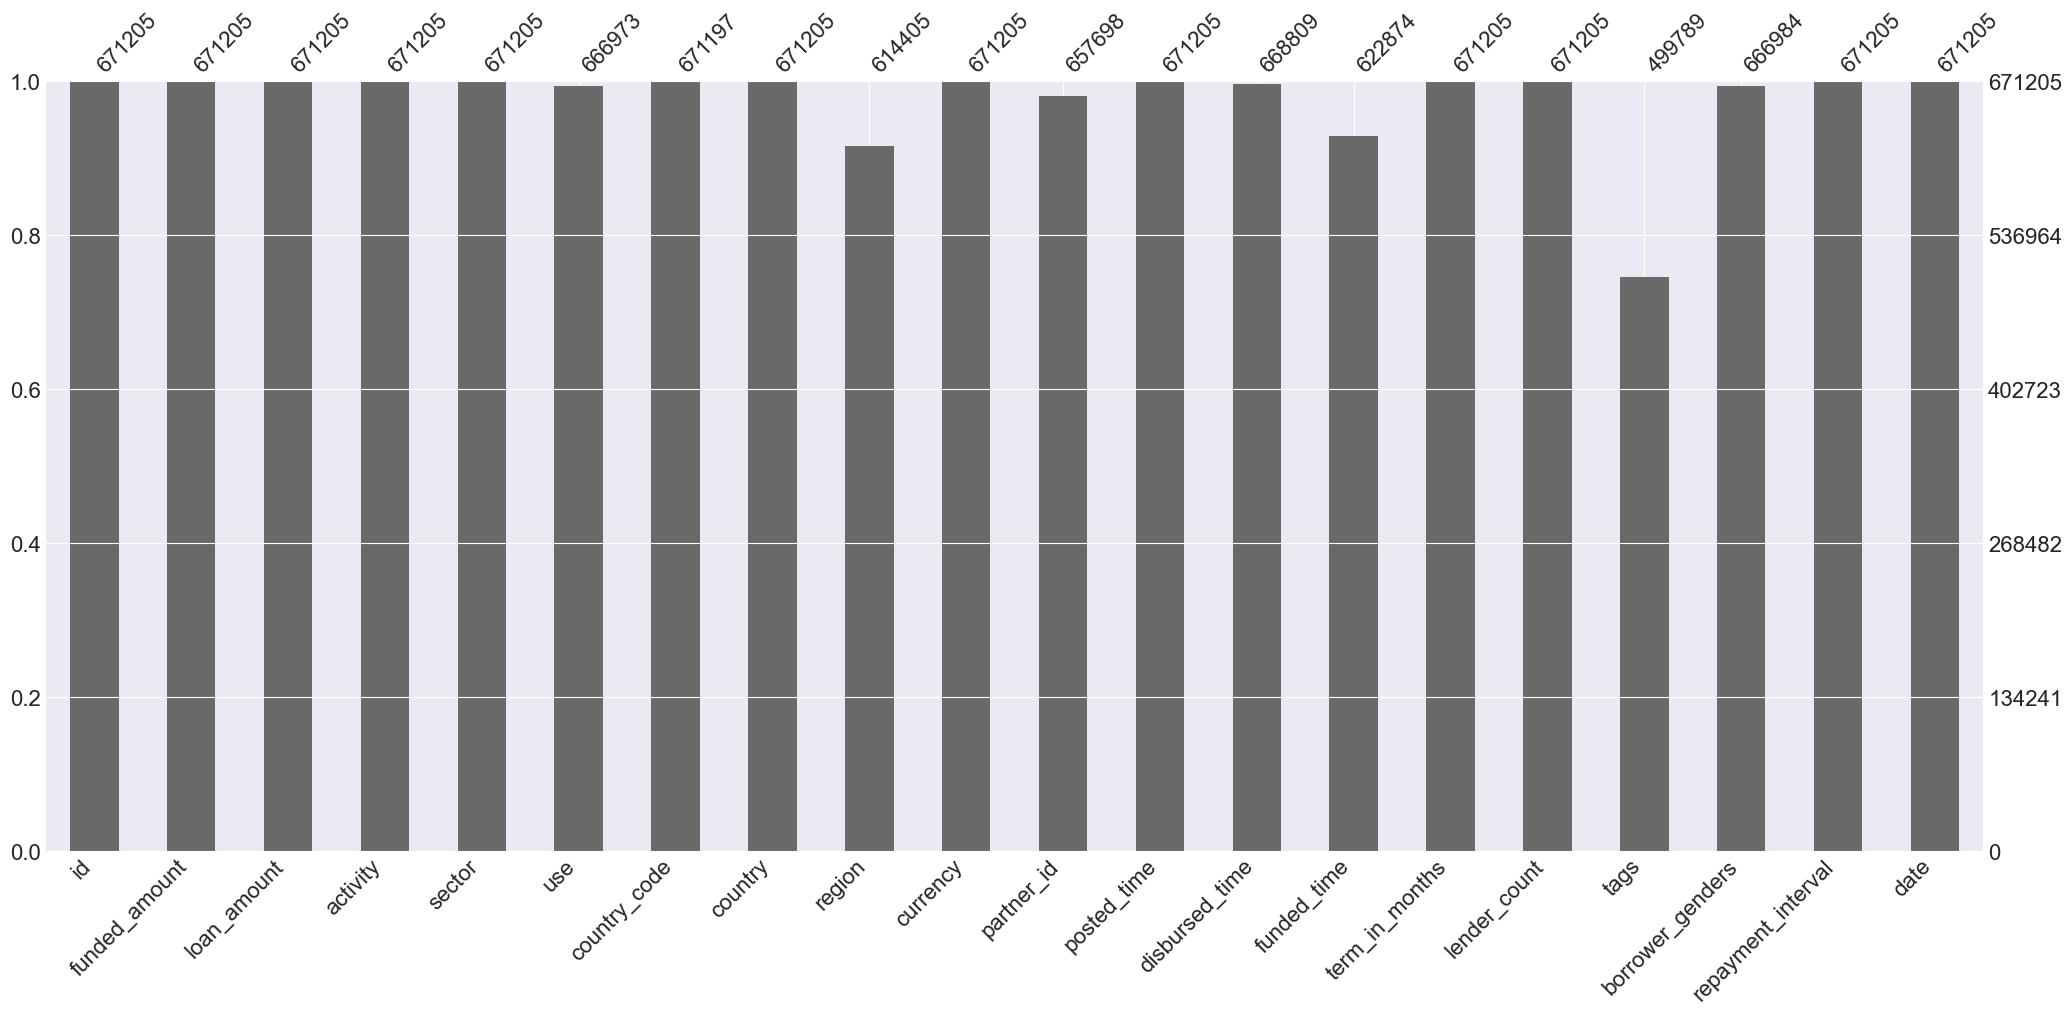

In [254]:
msno.bar(df_kiva_loans)

Посмотрим на распределение пропущенных данных

<Axes: >

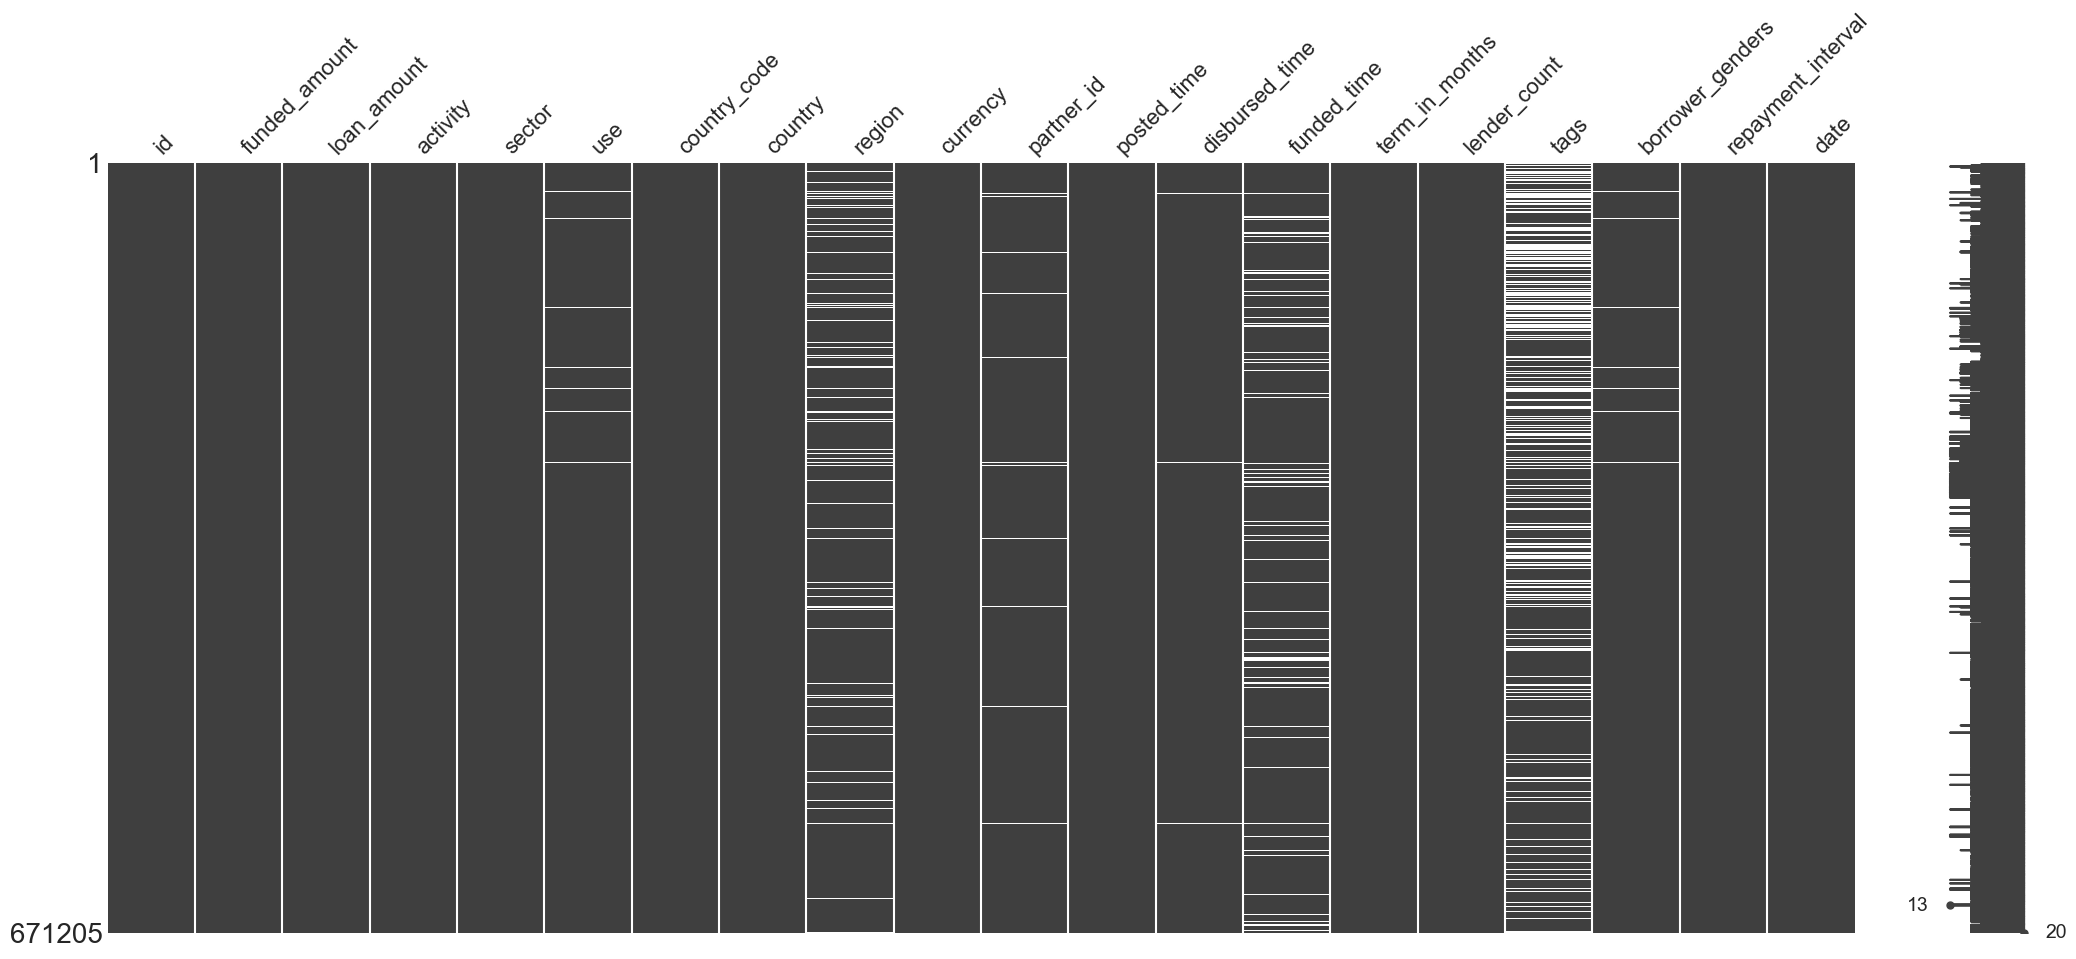

In [255]:
msno.matrix(df_kiva_loans)

Столбец тегов содержит много пропущенных значений. Столбец с датой собранной на платформе суммы имеет около 8% пропусков. Возможно сумма была не собрана или это ошибка. У нас более 600 тысяч строк и мы может удалить пропуски без потрери качества.

Изучим каждый атрибут датасеа и для каждого выведем статистику.

In [256]:
df_kiva_loans.dtypes

id                      int64
funded_amount         float64
loan_amount           float64
activity               object
sector                 object
use                    object
country_code           object
country                object
region                 object
currency               object
partner_id            float64
posted_time            object
disbursed_time         object
funded_time            object
term_in_months        float64
lender_count            int64
tags                   object
borrower_genders       object
repayment_interval     object
date                   object
dtype: object

In [257]:
df_kiva_loans.describe(include=[np.number])  # включая числовые данные

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


In [258]:
df_kiva_loans.describe(include=[object])

,activity,sector,use,country_code,country,region,currency,posted_time,disbursed_time,funded_time,tags,borrower_genders,repayment_interval,date
count,671205,671205,666973,671197,671205,614405,671205,671205,668809,622874,499789,666984,671205,671205
unique,163,15,424912,86,87,12695,67,667399,5719,498007,86719,11298,4,1298
top,Farming,Agriculture,to buy a water filter to provide safe drinking...,PH,Philippines,Kaduna,PHP,2017-05-15 00:00:00+00:00,2017-02-01 08:00:00+00:00,2016-09-21 13:03:24+00:00,user_favorite,female,monthly,2017-03-20
freq,72955,180302,5217,160441,160441,10000,160440,25,2800,33,27088,426502,342717,1308


Выводы и результаты по качеству данных:

- В датасете содержатся данные о 87 странах, где люди запрашивали помощь в финансировании.
- Наибольшее количество займов в Филиппинах.
- Наиболее популярная категория - Сельское хозяйство.
- Большой разброс значений числовых данных.
- Здесь содержится 11298 разных значений пола, что невозможно. Требуется проверка и исправление.
- Среднее финансирование в мире составляет 786 $, в медиане - 450 $.
- Всего есть 1298 дат, в которые были опубликованы заявки на кредит. 

Рассмотрим информацию о пользователях платформы.

Из каких стран пользователи? Для нашлядности выведем страны, где пользователей более 0,5%

In [259]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True) > 0.005]

In [260]:
list_countries = list(countries.index)

In [261]:
countries

country
Philippines      160441
Kenya             75825
El Salvador       39875
Cambodia          34836
Pakistan          26857
Peru              22233
Colombia          21995
Uganda            20601
Tajikistan        19580
Ecuador           13521
Paraguay          11903
Nicaragua         11781
India             11237
Vietnam           10843
Nigeria           10136
Bolivia            8806
Lebanon            8792
Armenia            8631
Palestine          8167
Samoa              7396
Guatemala          7310
Rwanda             6735
Mali               6639
Honduras           6557
Indonesia          6214
United States      6093
Kyrgyzstan         5774
Togo               5749
Mexico             5741
Sierra Leone       5415
Tanzania           5219
Ghana              4374
Jordan             4167
Zimbabwe           4034
Madagascar         3821
Liberia            3682
Haiti              3618
Mozambique         3483
Name: count, dtype: int64

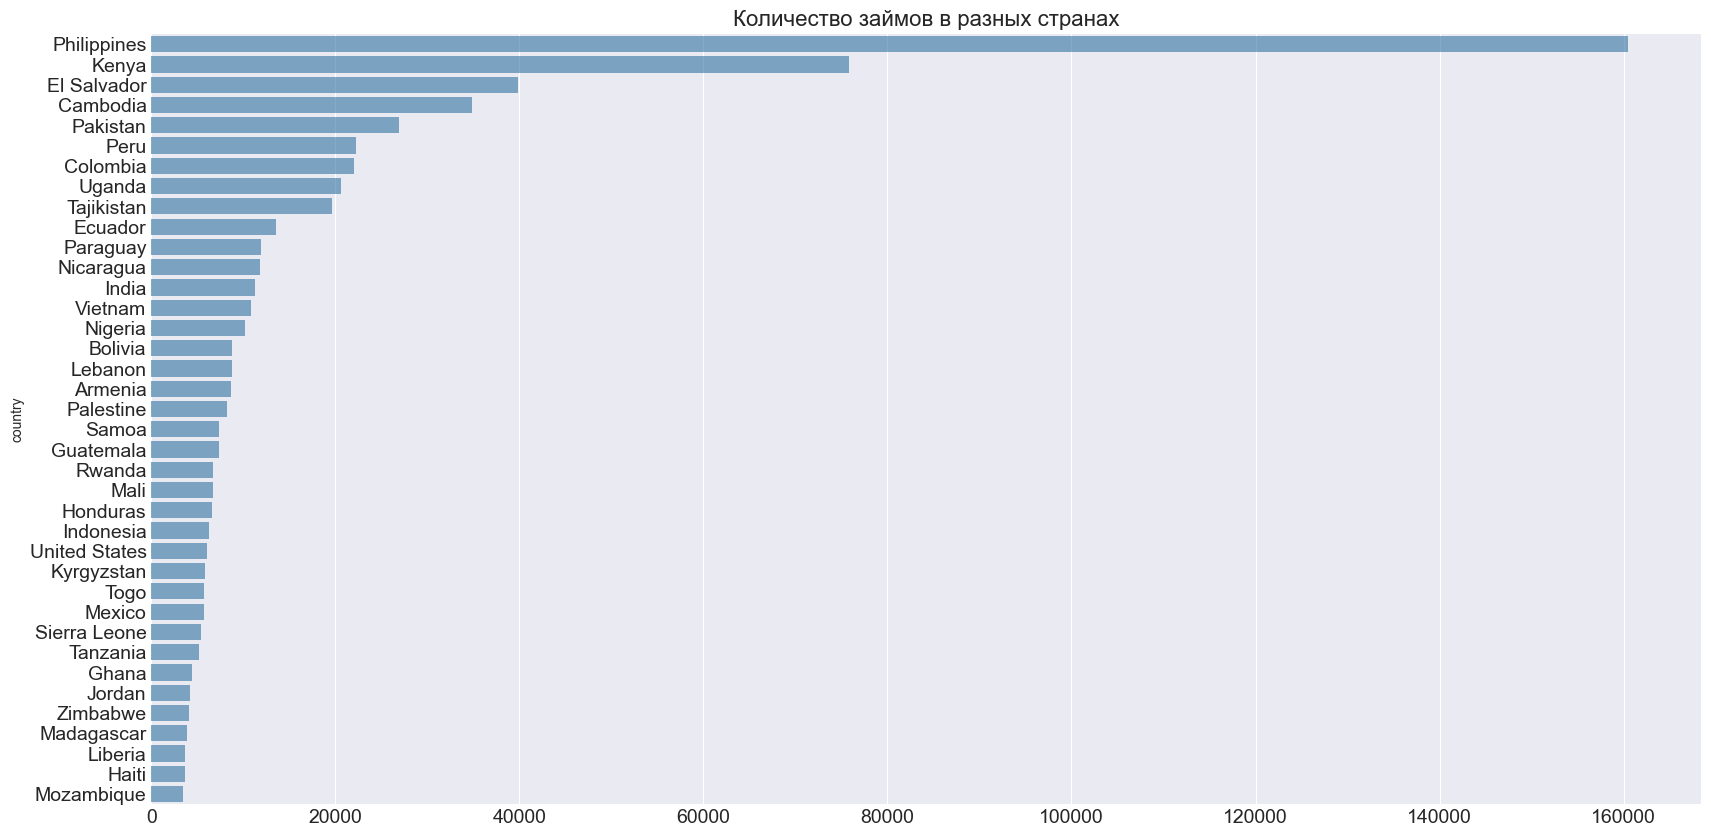

In [262]:
plt.figure(figsize=(20, 10))
plt.title('Количество займов в разных странах', fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(x=countries.values, y=countries.index, alpha=0.6)
plt.show()

Лидерами являются Филлипины и Кения. Возможно там маленькие займы. В списке нет стран ЕС и много стран Африки.

Сгруппируем страны по частям света. 

In [263]:
df_mpi.head(3)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754


In [264]:
df_mpi_grouped = df_mpi.groupby(['ISO', 'country', 'world_region'])['MPI'].mean().fillna(0).reset_index()

In [265]:
df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')

In [266]:
regions = df_kiva_loans['world_region'].value_counts()

In [267]:
region_list = regions.index.to_list()

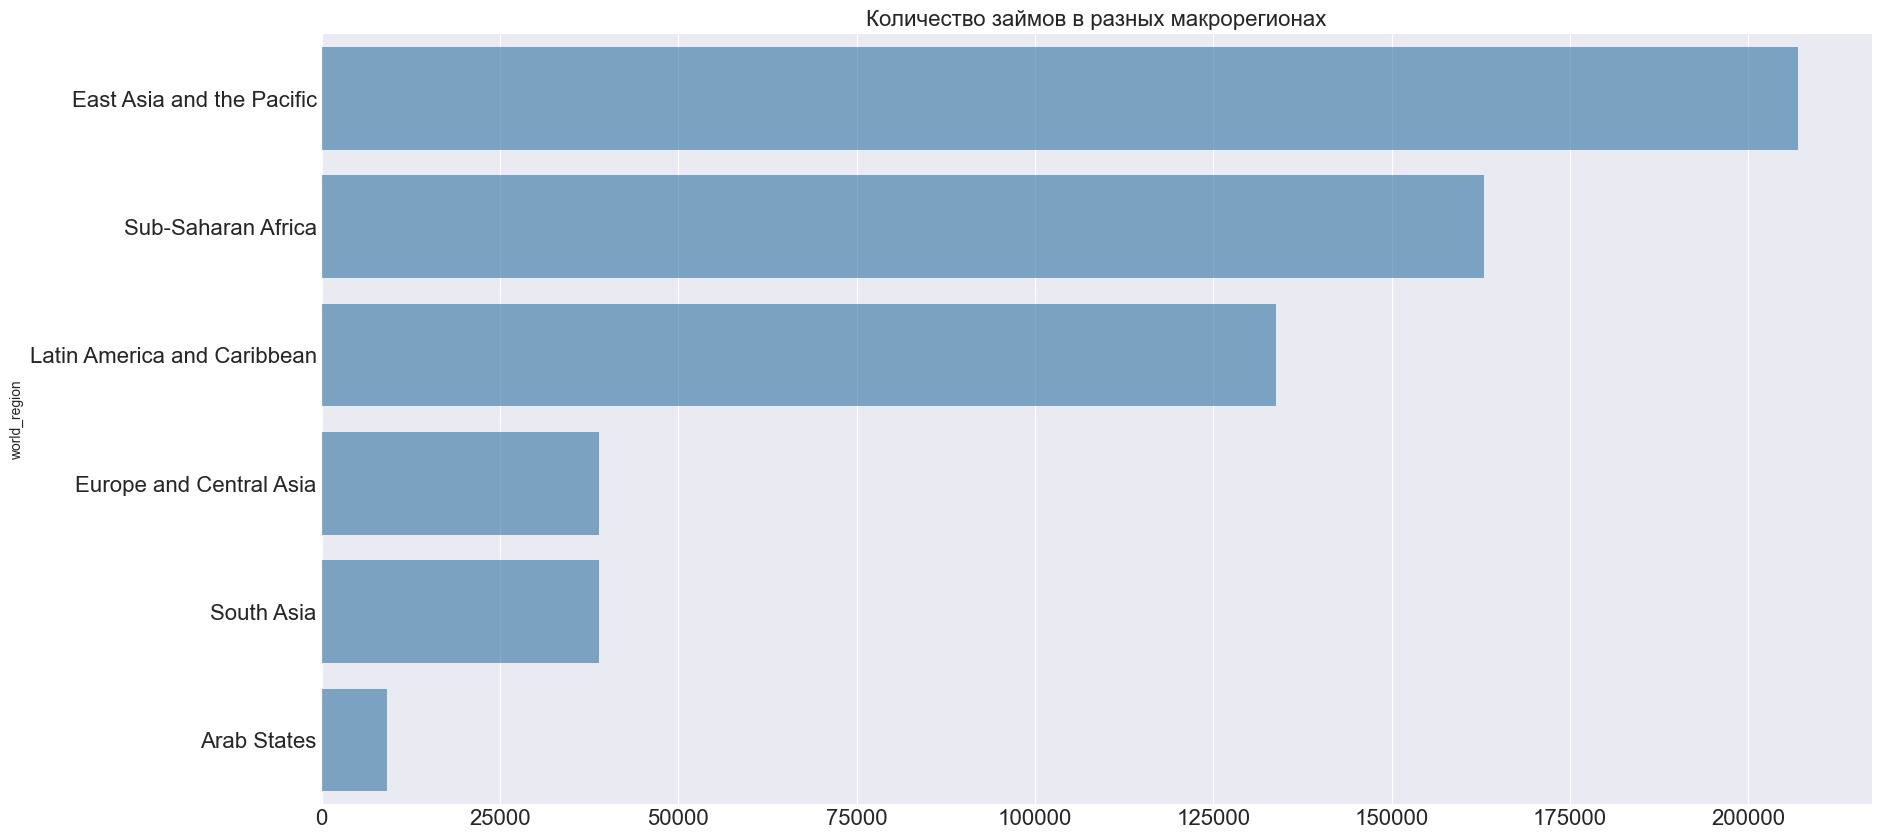

In [268]:
plt.figure(figsize=(20, 10))
plt.title('Количество займов в разных макрорегионах', fontsize=16)
plt.tick_params(labelsize=16)
sns.barplot(x=regions.values, y=regions.index, alpha=0.6)
plt.show();

Мы видим. что в странах восточной Азии, Африки и Латинской Америки, в то время как в Южной и Центральной Азии, Европе и Арабсикх странах количество займов низкое. Возможно эти страны с высоким mpi (уровнем жизни) или про Kiva там просто мало кто знает.

Рассмотрим гендерную сторону заёмщиков. 

In [269]:
df_kiva_loans['borrower_genders'].value_counts()

borrower_genders
female                                                                                                                                                                                            426502
male                                                                                                                                                                                              134710
female, female                                                                                                                                                                                     12164
female, female, female                                                                                                                                                                             11676
female, female, female, female                                                                                                                                                     

Мы видим, что во многих проектах заемщиком является группа людей. Они обозначены как "женщина, женщина, женщина" или "мужчина, женщина". Ткая группировка людей по проектам объясняет наличие 12 тысяч полов. 

Построим групповую диаграмму. 

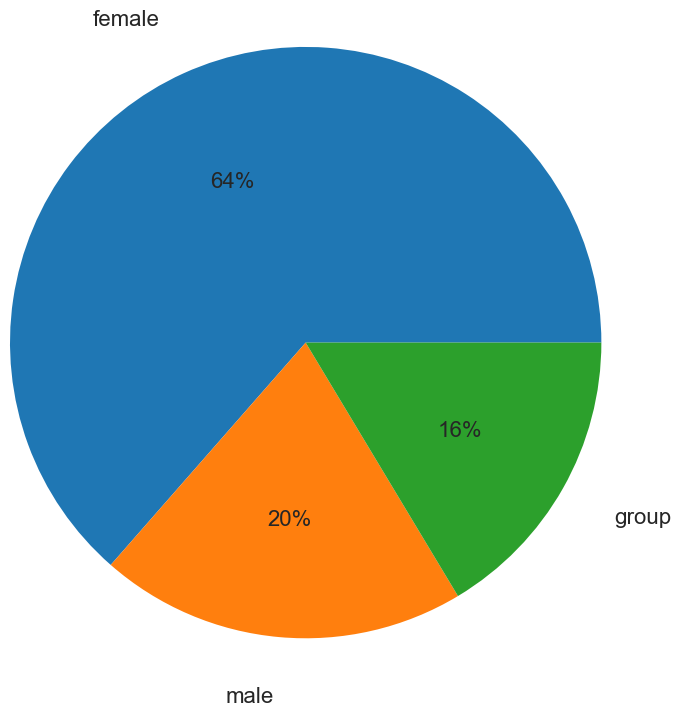

In [270]:
df_kiva_loans['borrower_genders'] = [elem if elem in ['female', 'male'] else 'group' for elem in df_kiva_loans['borrower_genders']]
borrowers = df_kiva_loans['borrower_genders'].value_counts()
plot = borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

Выясняется, что большинство заемщиков - женщины. В каких странах такая ситуация?

In [271]:
df_gender_by_country = df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)].groupby(
    ['country', 'borrower_genders'])['borrower_genders'].count().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack('borrower_genders').fillna(0).sort_values(by=['female', 'male'])[-20:]

df_gender_by_country = df_gender_by_country[['female', 'male', 'group']]

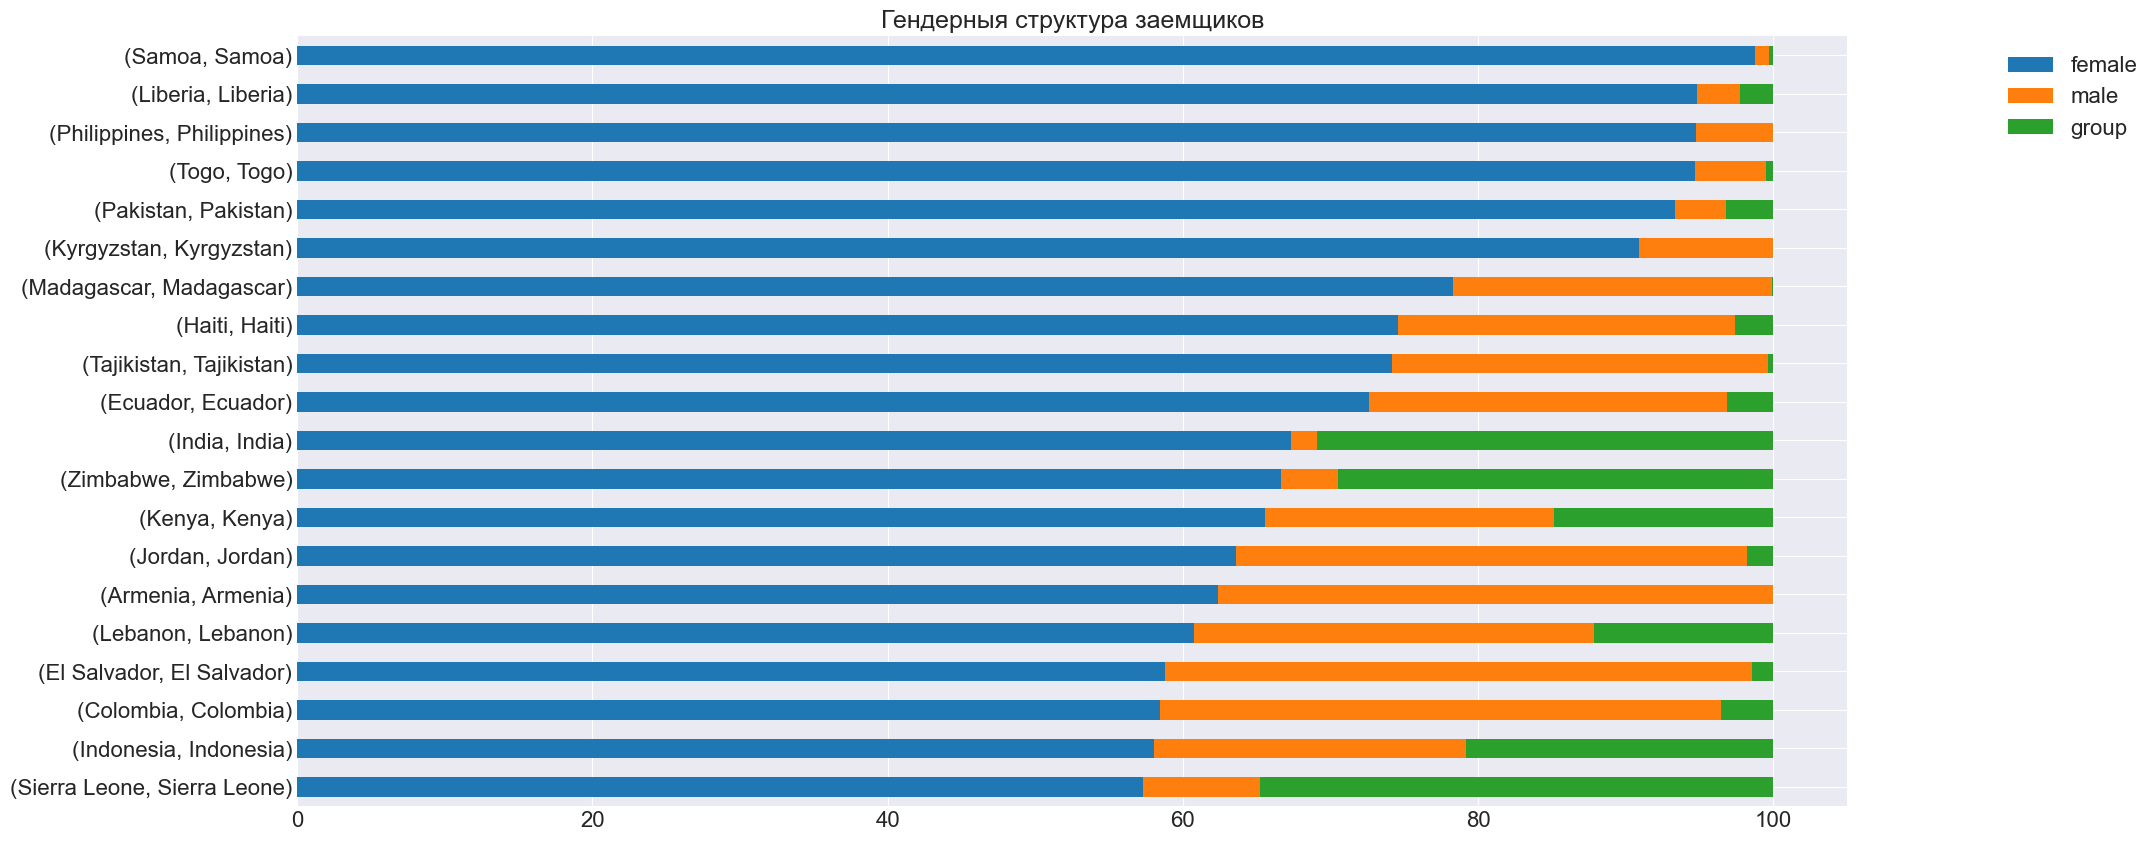

In [272]:
plot = df_gender_by_country.plot.barh(
    figsize=(20, 10),
    fontsize=16,
    stacked=True,
    title='Гендерныя структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [273]:
df_gender_by_country['male']

country       country     
Sierra Leone  Sierra Leone     7.959372
Indonesia     Indonesia       21.097522
Colombia      Colombia        38.008638
El Salvador   El Salvador     39.791850
Lebanon       Lebanon         27.070064
Armenia       Armenia         37.597034
Jordan        Jordan          34.557235
Kenya         Kenya           19.564787
Zimbabwe      Zimbabwe         3.891919
India         India            1.753137
Ecuador       Ecuador         24.236373
Tajikistan    Tajikistan      25.459653
Haiti         Haiti           22.830293
Madagascar    Madagascar      21.617378
Kyrgyzstan    Kyrgyzstan       9.109803
Pakistan      Pakistan         3.440444
Togo          Togo             4.853018
Philippines   Philippines      5.221234
Liberia       Liberia          2.906029
Samoa         Samoa            0.919416
Name: male, dtype: float64

Рассмотрим зависимость пола заёмщика от региона и сектора экономики

In [306]:
genders_by_region = df_kiva_loans.groupby(
    ["borrower_genders", "world_region"], as_index=False)["loan_amount"].count()

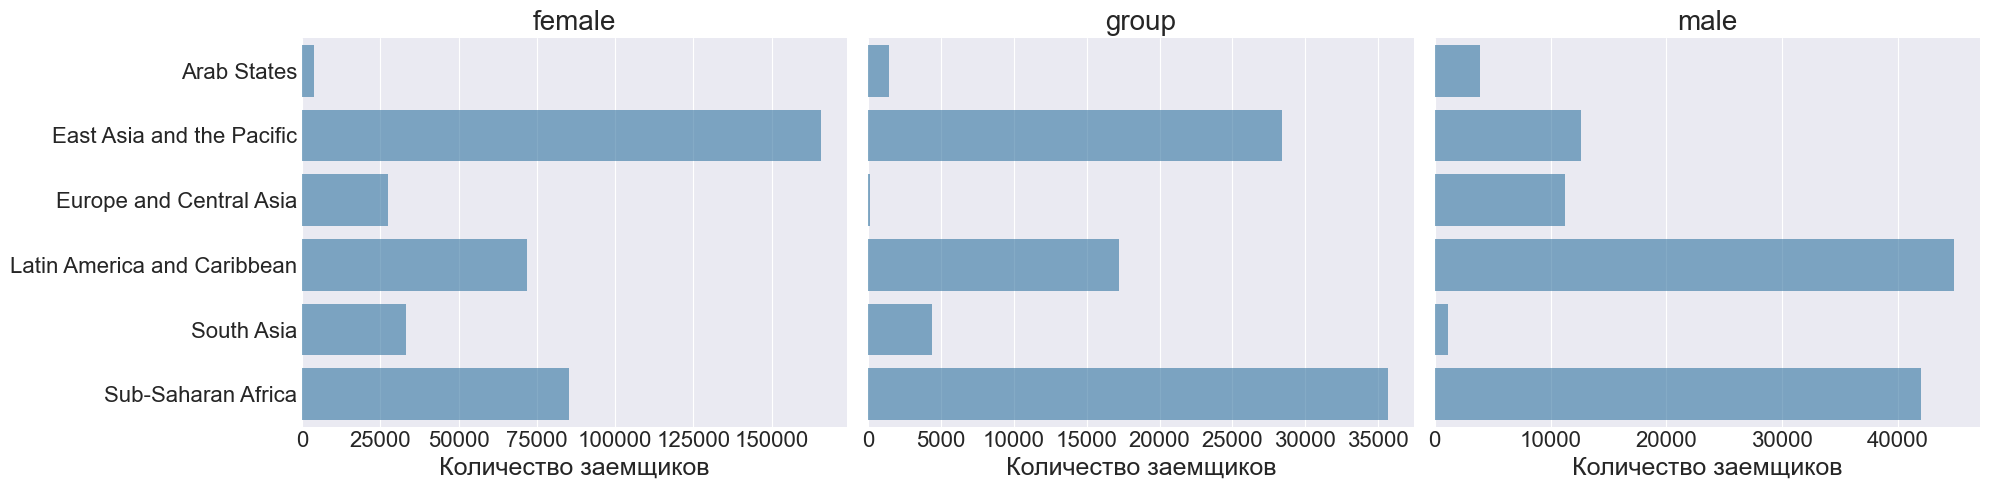

In [307]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5))

for ax, gender in zip(axes.ravel(), genders_by_region["borrower_genders"].unique()):
    
    df_reg = genders_by_region[genders_by_region["borrower_genders"] == gender]
    
    sns.barplot(y='world_region', x='loan_amount', data=df_reg, alpha=0.6, ax=ax)

    ax.set_title(gender, fontsize=20)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(labelsize=16)
    ax.set_xlabel('Количество заемщиков', fontsize=18)
    plt.tight_layout()

Наибольшее число займов среди женщин в странах Восточной Азии и Океании. Заемщики мужчины лидируют в Латинской Америке и Центральной Африке. В Арабских государствах и Южной Азии низкий общий уровень займов.

In [308]:
genders_by_sector = df_kiva_loans.groupby(
    ["borrower_genders", "sector"], as_index=False)["loan_amount"].count()

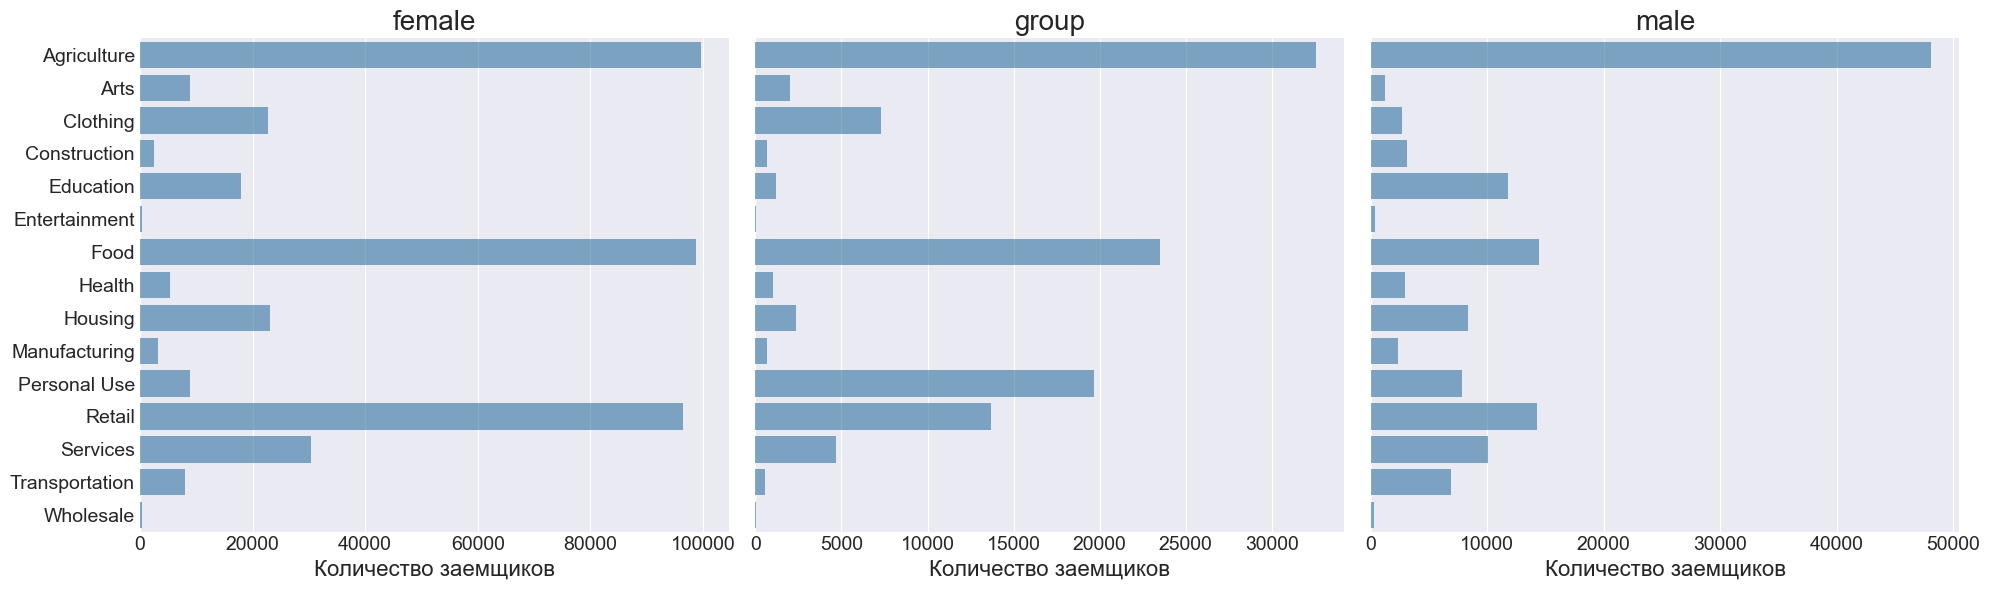

In [309]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 6))

for ax, gender in zip(axes.ravel(), genders_by_sector["borrower_genders"].unique()):
    
    df_sec = genders_by_sector[genders_by_sector["borrower_genders"] == gender]
    
    sns.barplot(y='sector', x='loan_amount', data=df_sec, alpha=0.6, ax=ax)

    ax.set_title(gender, fontsize=20)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(labelsize=14)
    ax.set_xlabel('Количество заемщиков', fontsize=16)
    plt.tight_layout()

Сельское хозяйство является основным для всех типов пола заемщиков.

Среди женщины и групповых заемщиков распространены займы для продовольственных товаров и розничной торговли.

Количество займов. Для чего людям нужны кредиты? Начнем с секторов экономики.

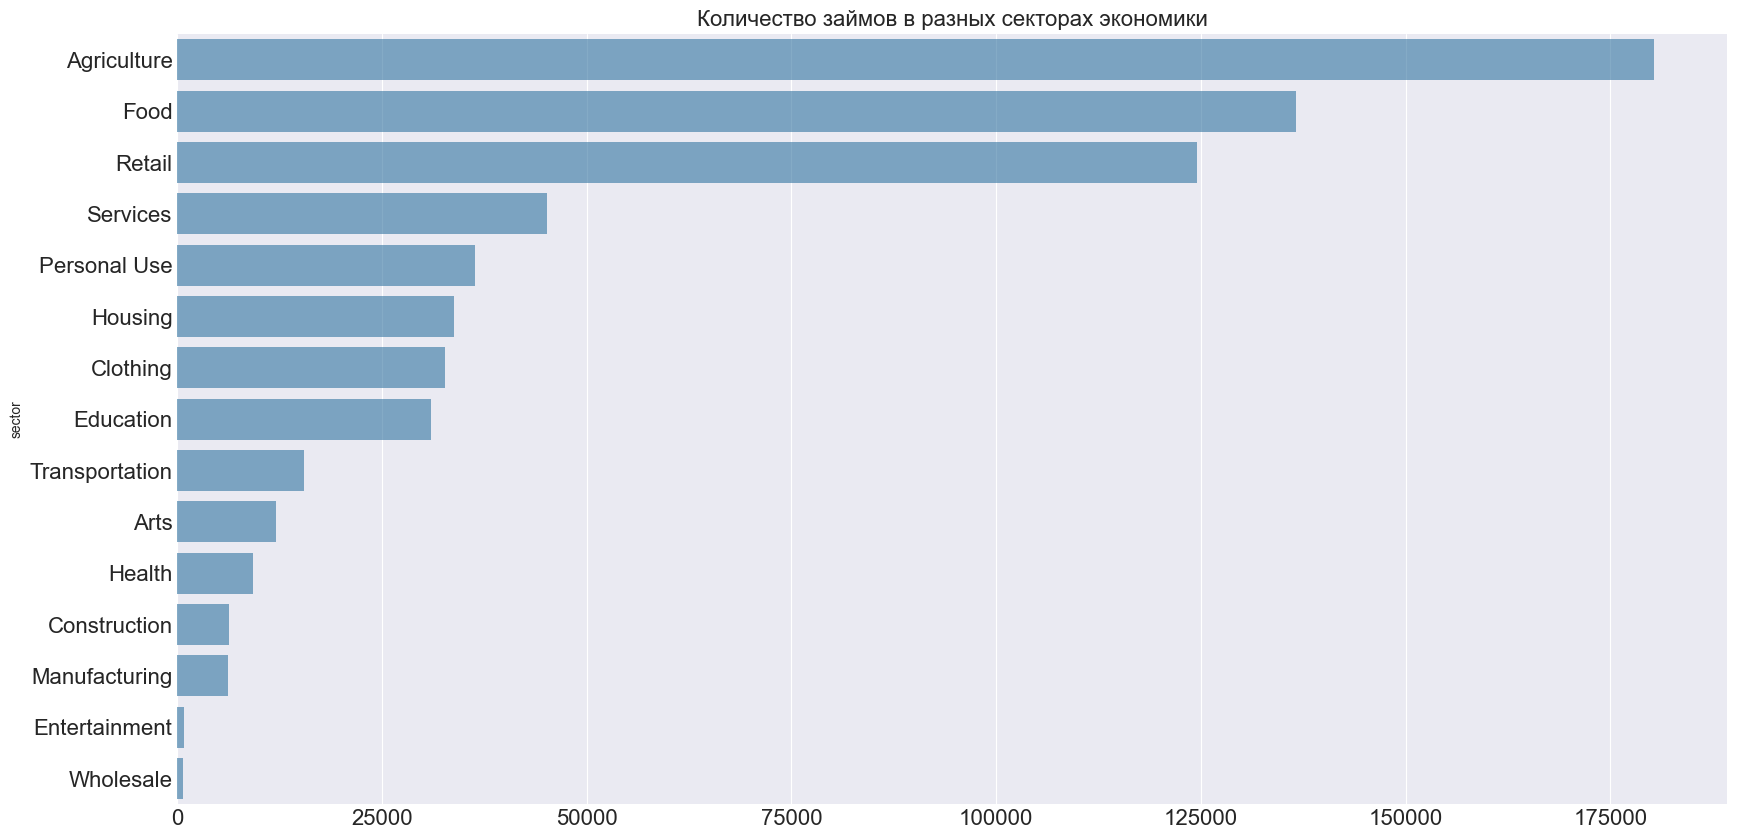

In [274]:
sectors = df_kiva_loans['sector'].value_counts()

plt.figure(figsize=(20, 10))
plt.title('Количество займов в разных секторах экономики', fontsize=16)
plt.tick_params(labelsize=16)
sns.barplot(x=sectors.values, y=sectors.index, alpha=0.6)
plt.show();

На первом месте сельское хозяйство, далее пищевая промышленность и торговля. Значительную долю занимают кредиты на личные нужды. Строительство, производство, развлечения и оптовая торговля занимают наименьшие доли кредитования.

Посмотрим по видам деятельности

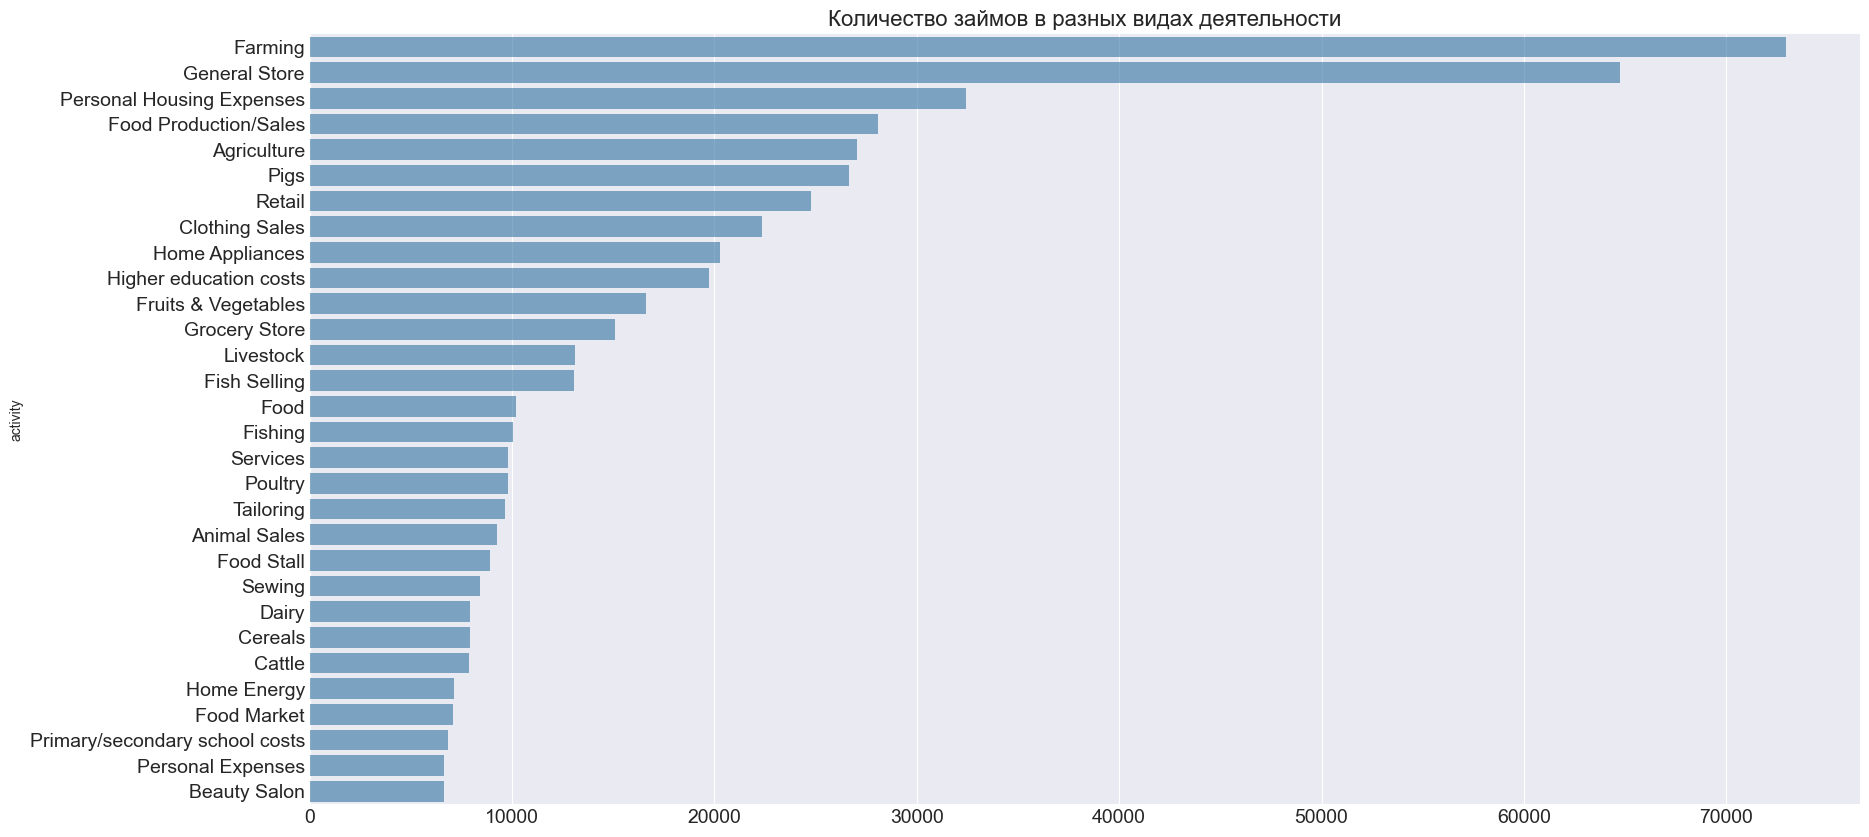

In [275]:
activities = df_kiva_loans['activity'].value_counts().head(30)

plt.figure(figsize=(20, 10))
plt.title('Количество займов в разных видах деятельности', fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(x=activities.values, y=activities.index, alpha=0.6)
plt.show();

В лидерах Фермерство, Розничные магазины, домашнее хозяйство и расходы на жилье. 

Построим рейтинг целевого назначения займа

In [276]:
activities =  df_kiva_loans['use'].value_counts().head(25)
activities.head(25)

use
to buy a water filter to provide safe drinking water for their family.                                                          5217
to buy a water filter to provide safe drinking water for her family.                                                            4082
To buy a water filter to provide safe drinking water for their family.                                                          2141
to build a sanitary toilet for her family.                                                                                      1708
to build a sanitary toilet for her family                                                                                       1599
to buy ingredients for her food production business                                                                             1419
to purchase more groceries to sell.                                                                                             1409
to buy feed and other supplies to raise her pigs.                

В лидерах базовые вещи, такие как покупака фильтров для воды, оборудование септиков, светильники на солнечных батарейках.

Сравним наиболее популярные виды займов. Посмотрим на топ 10 в каждой категории по признакам sector и activity

In [277]:
loans_by_activity_sector = df_kiva_loans[df_kiva_loans['sector'].isin(sectors[:9].index.values)].groupby(
    ['sector', 'activity'])['loan_amount'].count().reset_index()

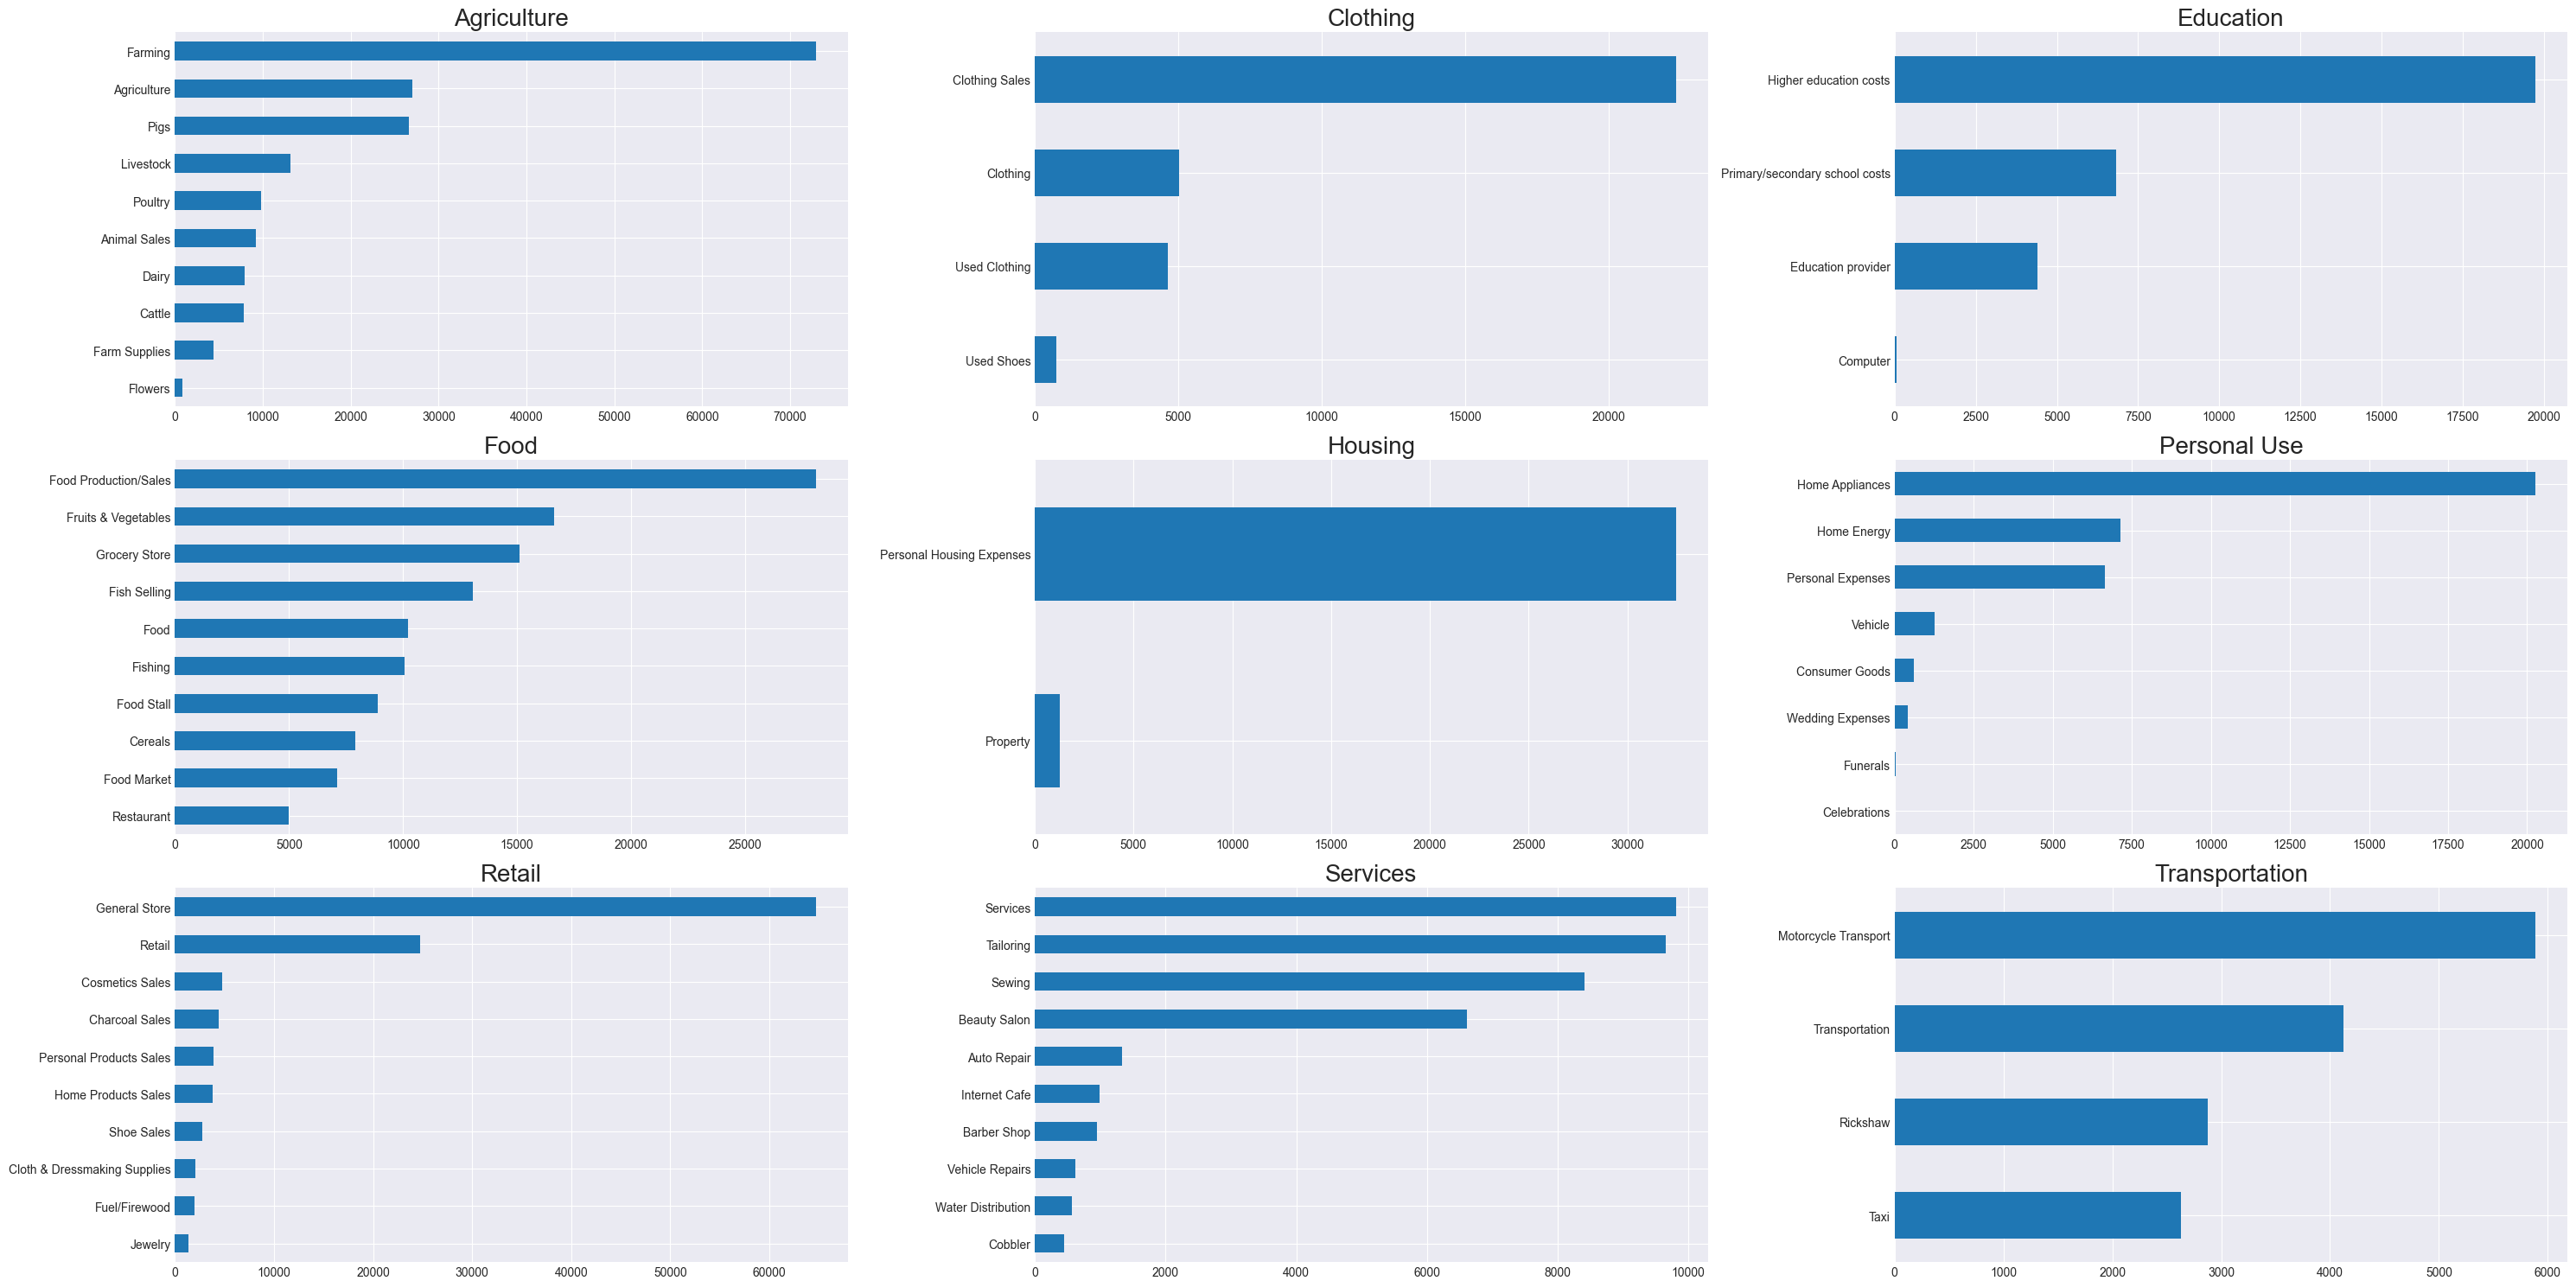

In [278]:
fig, axes = plt.subplots(3, 3, sharex=False, squeeze=False, figsize=(30, 15))

for ax, q in zip(axes.ravel(), loans_by_activity_sector.sector.unique()):
    tmp_df = loans_by_activity_sector[loans_by_activity_sector.sector.eq(q)].dropna().sort_values(by='loan_amount')[-10:]
    ax.set_title(q, fontsize=20)
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()

    tmp_df.plot.barh(x='activity', ax=ax, legend=None, fontsize=10)

Мы видим, что наибольшая доля займов направлена на деятельность с невысокой добавленной стоимостью, такую как сельское хозяйство, розничная торговля, сервис и образование. 

Рассмотрим объем финансирования. Построим график распределения сумм займов

C:\Users\mmd28\AppData\Local\Temp\ipykernel_7040\4016413409.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_kiva_loans['loan_amount'], axlabel=False)


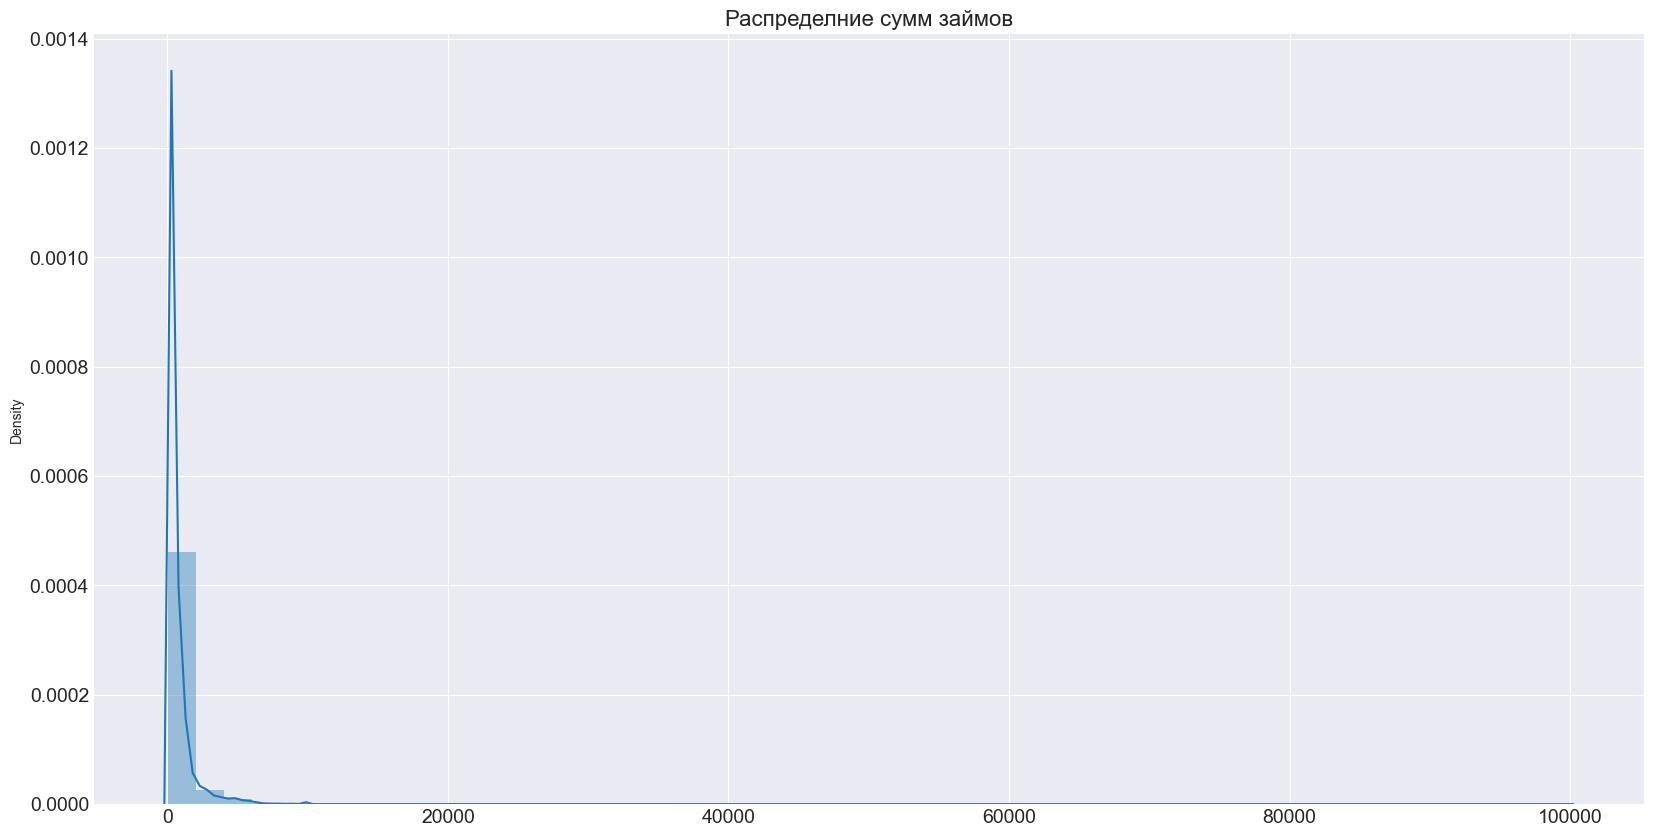

In [279]:
plt.figure(figsize=(20, 10))
plt.title('Распределние сумм займов', fontsize=16)
plt.tick_params(labelsize=14)

sns.distplot(df_kiva_loans['loan_amount'], axlabel=False)
plt.show();

Мы видим возможные выбросы. Исключим их по правилу 3-х сигм

Text(0.5, 1.0, 'Распределние сумм займов')

<Figure size 2000x1000 with 0 Axes>

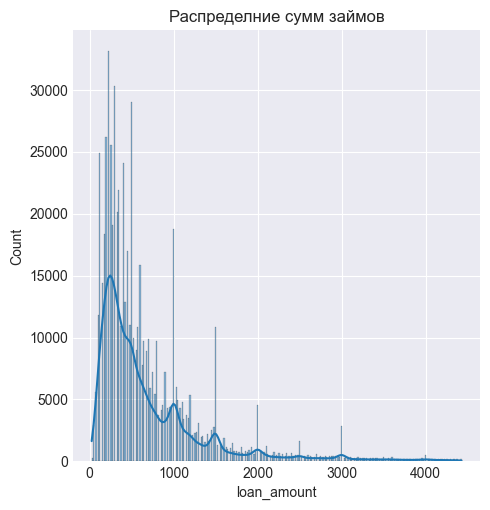

In [280]:
# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

plt.figure(figsize=(20, 10))
# plt.xticks(np.arange(0, max(df_kiva_loans_trimmed['loan_amount']+1), 200))

sns.displot(df_kiva_loans_trimmed['loan_amount'], kde=True)
plt.title('Распределние сумм займов')

Большинство займов составляет от 100 до 600 долларов США с пиковым значением 200 и 400 долларов США. Рассмотрим суммы займов по секторам экономики

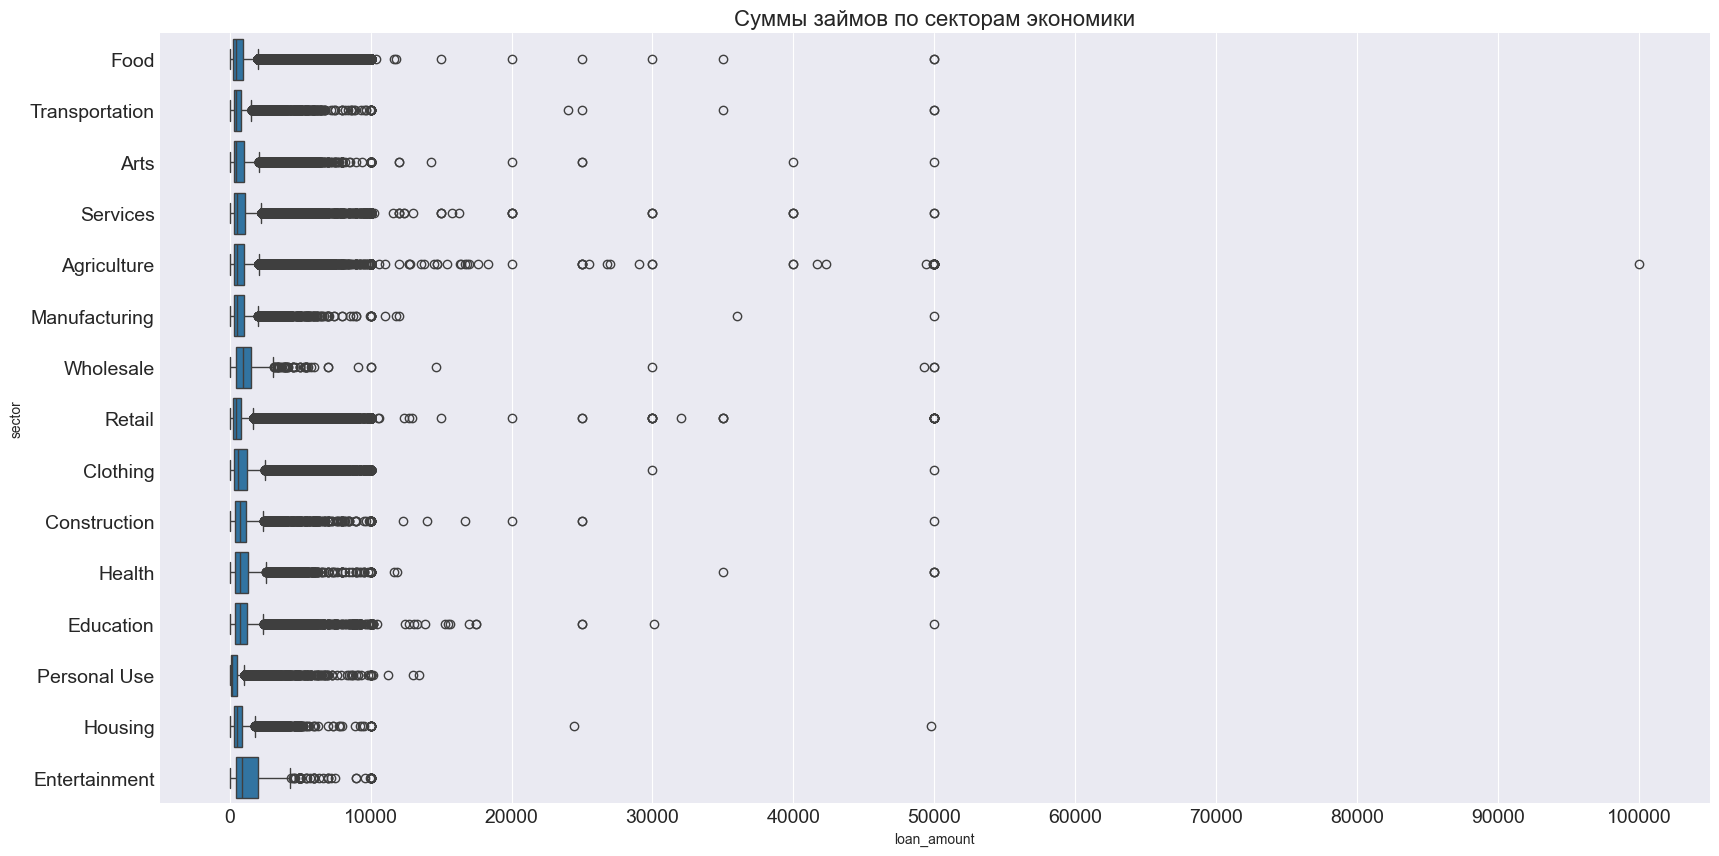

In [299]:
plt.figure(figsize=(20, 10))
plt.title('Суммы займов по секторам экономики', fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 10000))

sns.boxplot(data=df_kiva_loans, x='loan_amount', y='sector')
plt.show()

Мы видим, что в каждом секторе имеюся явные выбросы, особенно в значении 50 000. Вглянем на средние и медианные значения займов по секторам.

In [282]:
sector_mean_median = df_kiva_loans.groupby(['sector'])['loan_amount'].agg(
    median='median', mean='mean').sort_values(by='median', ascending=False)

sector_mean_median

,median,mean
sector,,
Wholesale,950.0,1569.716088
Entertainment,887.5,1673.674699
Education,725.0,998.565924
Health,725.0,1067.266616
Construction,700.0,1068.147735
Clothing,600.0,1139.237829
Services,550.0,1064.631148
Manufacturing,500.0,877.561211
Housing,500.0,701.549020


Средние значения превышают медианные. Избавимся от выбросов и построим график медианных значений.

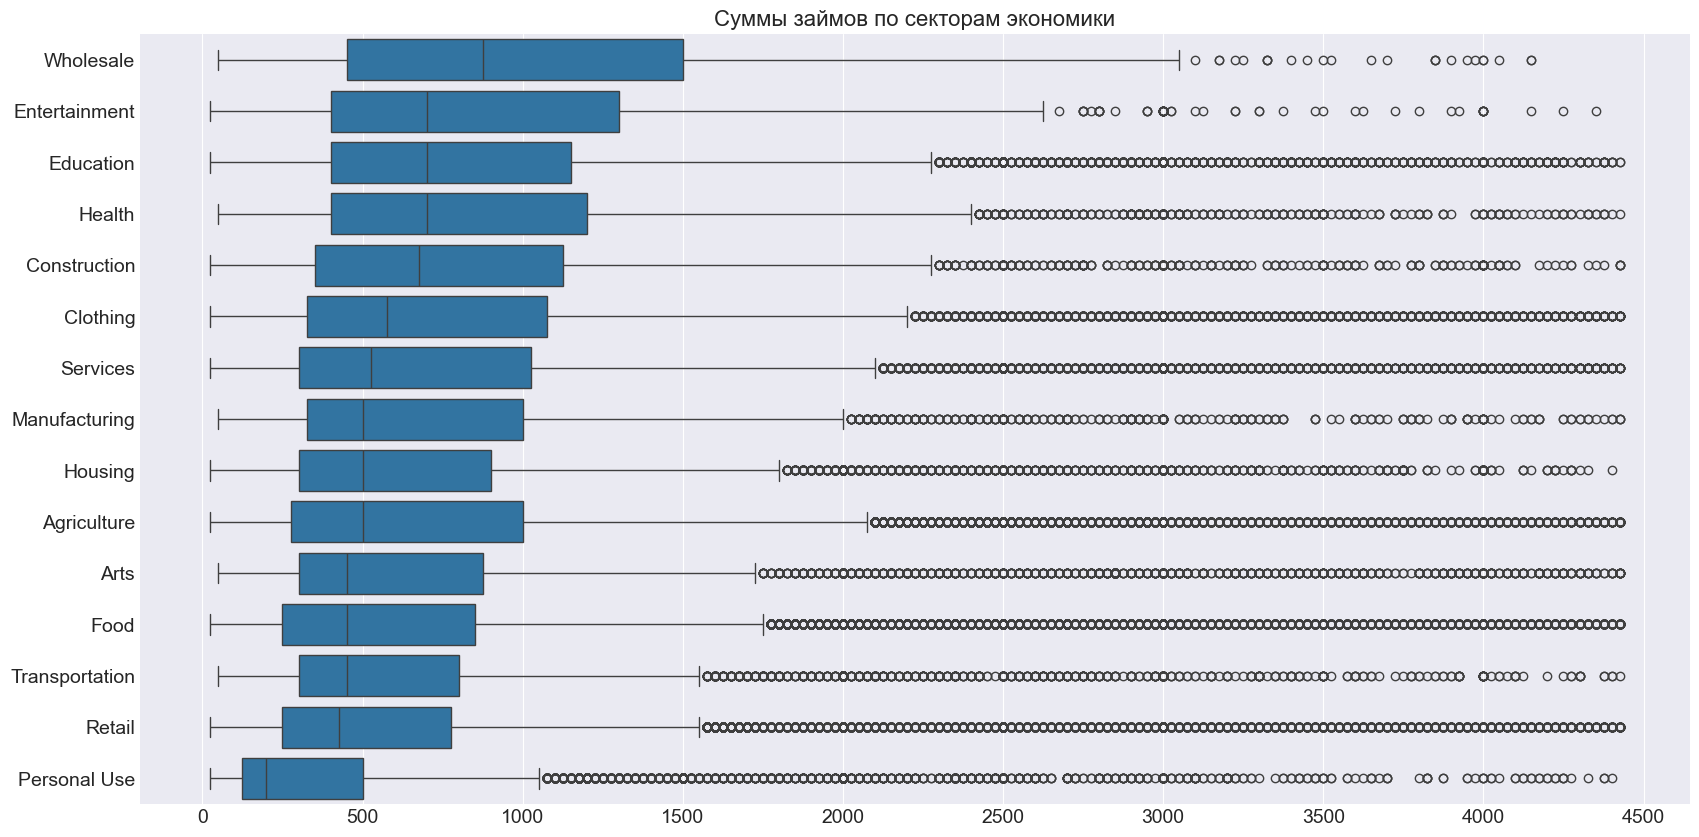

In [283]:
sort_order = sector_mean_median.index.to_list()

plt.figure(figsize=(20, 10))
plt.title('Суммы займов по секторам экономики', fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 500))

sns.boxplot(data=df_kiva_loans_trimmed, x='loan_amount',
            y='sector', order=sort_order).set(xlabel=None, ylabel=None)
plt.show()

Медиана дает устойчивую к выбросам оценку. Мы видим, что займы на личные нужны имеет наименьшее значение. Это группа заявок может говорить нам о случаях крайней нужды и бедности в различных странах. Так же мы видим, что самые большие значения имеют оптовая торговля, образование, здравоохранение и сфера развлечений.

Рассмотрим распределение по макрорегионам. 

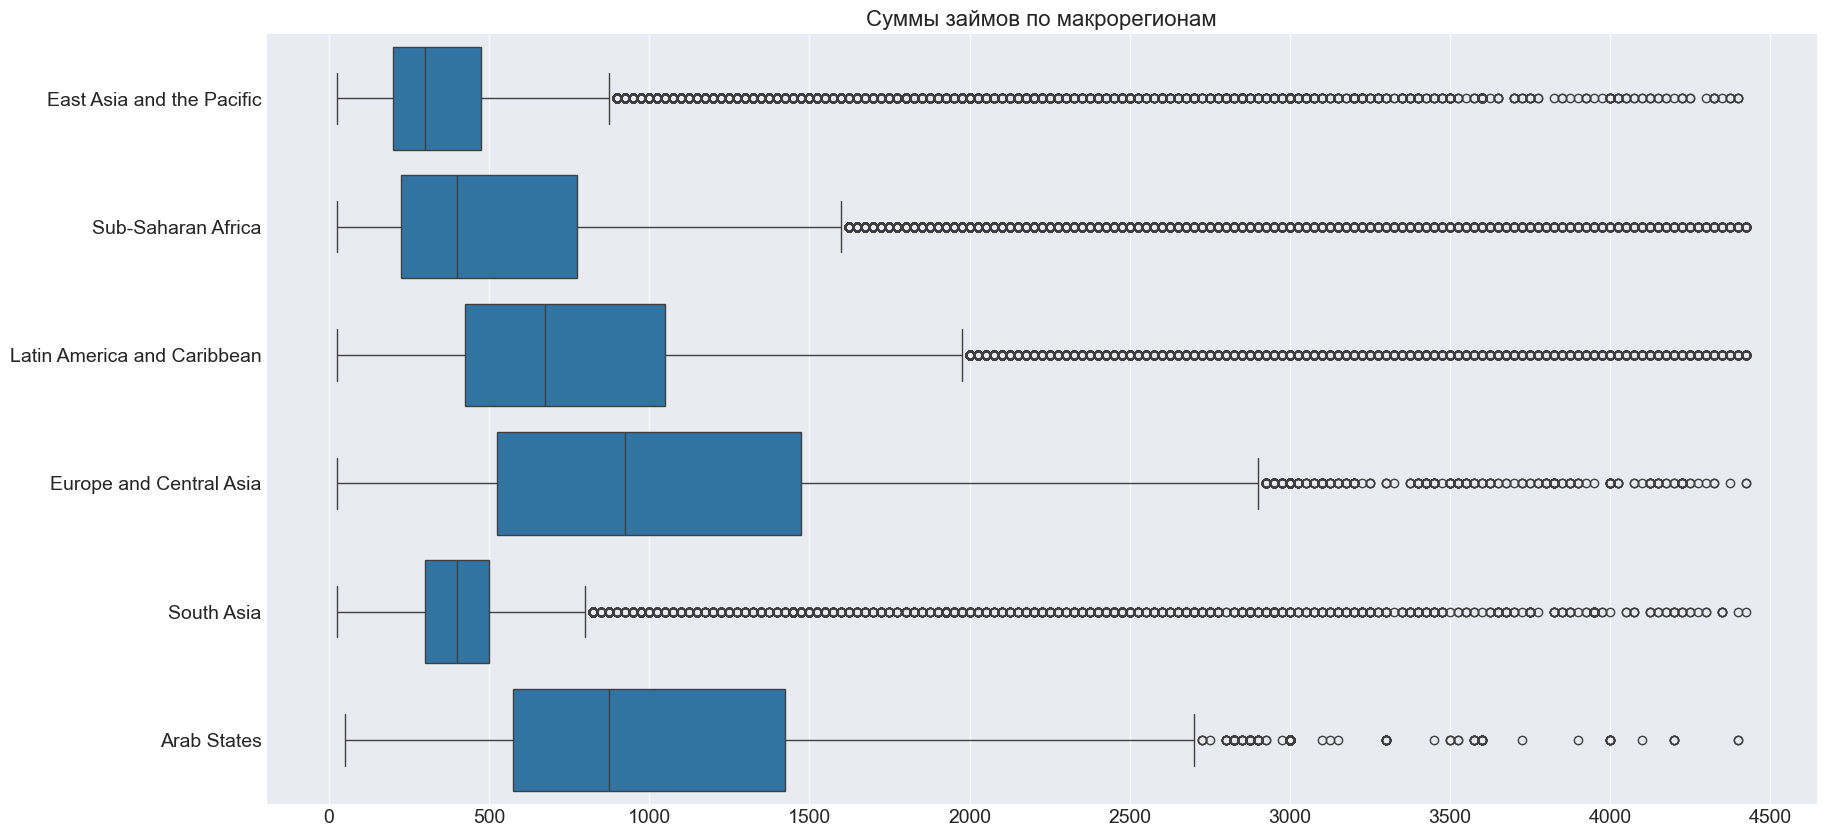

In [284]:
plt.figure(figsize=(20, 10))
plt.title('Суммы займов по макрорегионам', fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 500))

sns.boxplot(data=df_kiva_loans_trimmed, x='loan_amount',
            y='world_region', order=region_list).set(xlabel=None, ylabel=None)
plt.show()

Вероятно те регионы, где медиана нижу более бедные и требуют более короткие, небольшие, но частые займы. Лидеры Юго-Восточной Азии - Филлипины и Камбоджа. При этом Южная Азия выбивается из тренда и возможно является хорошим местом для Kivа для расширения своего присутствия.

Рассмотрим время ожидания средств. Отбросим строки с пропусками, вычислим интервал между датами и исключим заявки, для которых деньги сперва получают агенты на местах и только потом выдаются заемщикам.

In [285]:
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', "funded_time"], how='any', inplace=False)

In [286]:
dates = ['posted_time', 'disbursed_time']

Приведем даты к единому формату

In [ ]:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x: x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

Посчитаем интервалы

In [ ]:
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time'] - df_loans_dates['posted_time']

In [ ]:
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1)

In [290]:
# удалим выбросы по правилу 3 сигм
dev = (df_loans_dates['time_funding'] - df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()

In [291]:
# выберем значения больше нуля
df_loans_dates_trimmed = df_loans_dates[~(dev > 3 * std) & (df_loans_dates.loc[:, 'time_funding'] > 0)]

Поостроим график распределения количества дней до полного финансирования заявки

<Figure size 2000x1000 with 0 Axes>

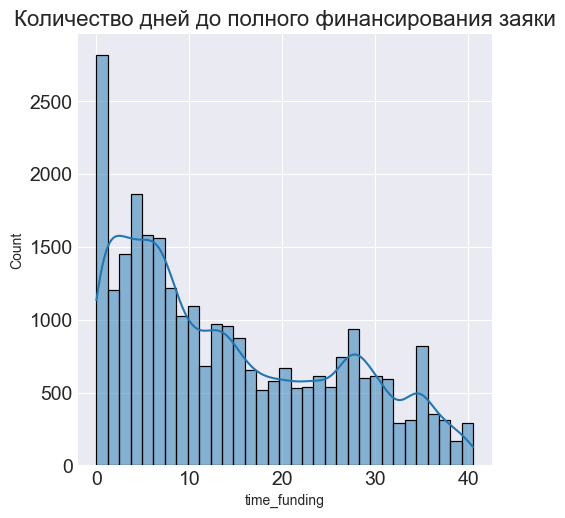

In [292]:
plt.figure(figsize=(20, 10))

sns.displot(df_loans_dates_trimmed['time_funding'], kde=True)
plt.title('Количество дней до полного финансирования заяки', fontsize=16)
plt.tick_params(labelsize=14)

Наибольшая часть заявок финансируется в течение 10 дней. Но есть длительность и до 40 дней. Посмотрим, есть ли зависимость между суммой займа временем финансирования.

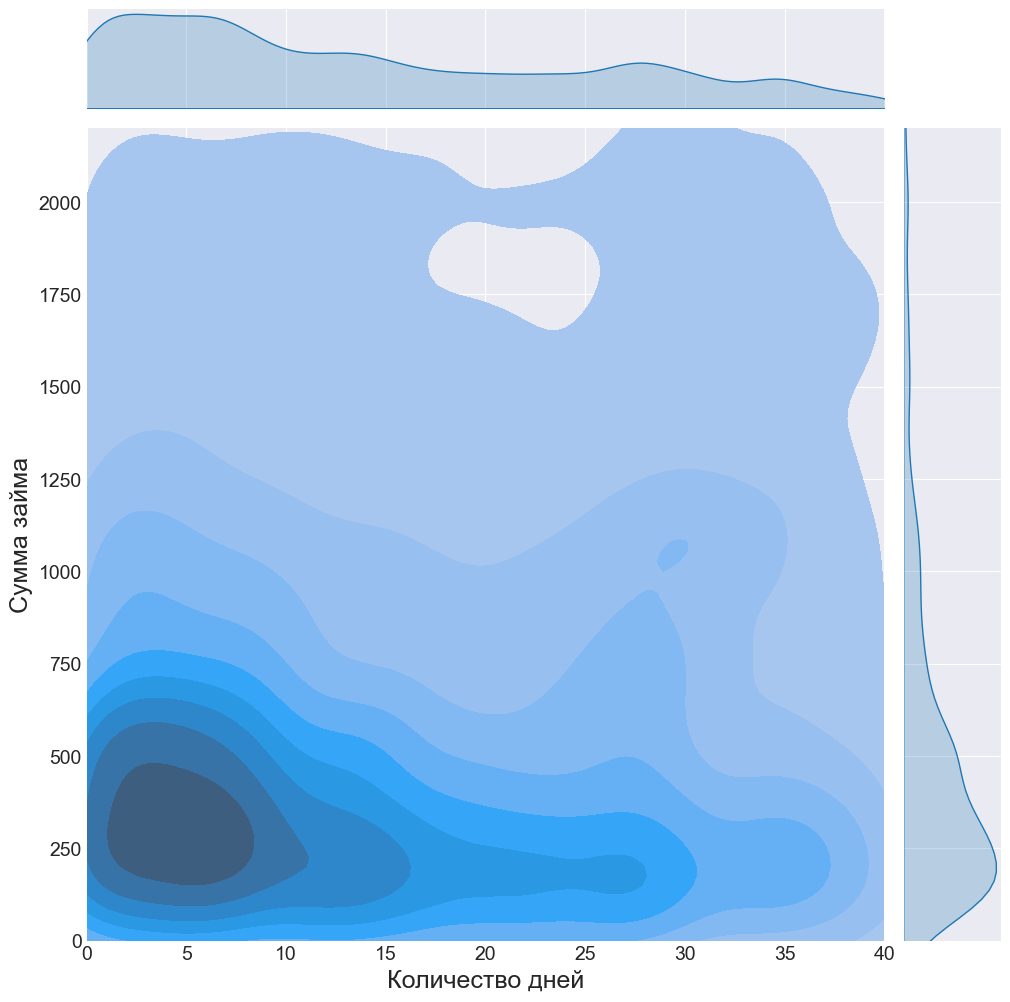

In [293]:
p = sns.jointplot(x="time_funding", y="loan_amount", 
                  data=df_loans_dates_trimmed, 
                  height=10, ratio=7, xlim=[0,40], kind='kde', fill=True, 
                  ylim=[0,2200]).set_axis_labels("Количество дней", "Сумма займа", size=18)

p.ax_joint.tick_params(labelsize=14)

plt.show()

Возрастающее количество дней, требуемое для финансирования заявки, можно объяснить возрастающей суммой.

Проверим наличие смещения интервалов ожидания по странам

In [294]:
df_country_median = df_loans_dates_trimmed.groupby(['world_region', 'country'])\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

df_country_median = df_country_median[df_country_median.country.isin(list_countries)].sort_values(by='time_funding')

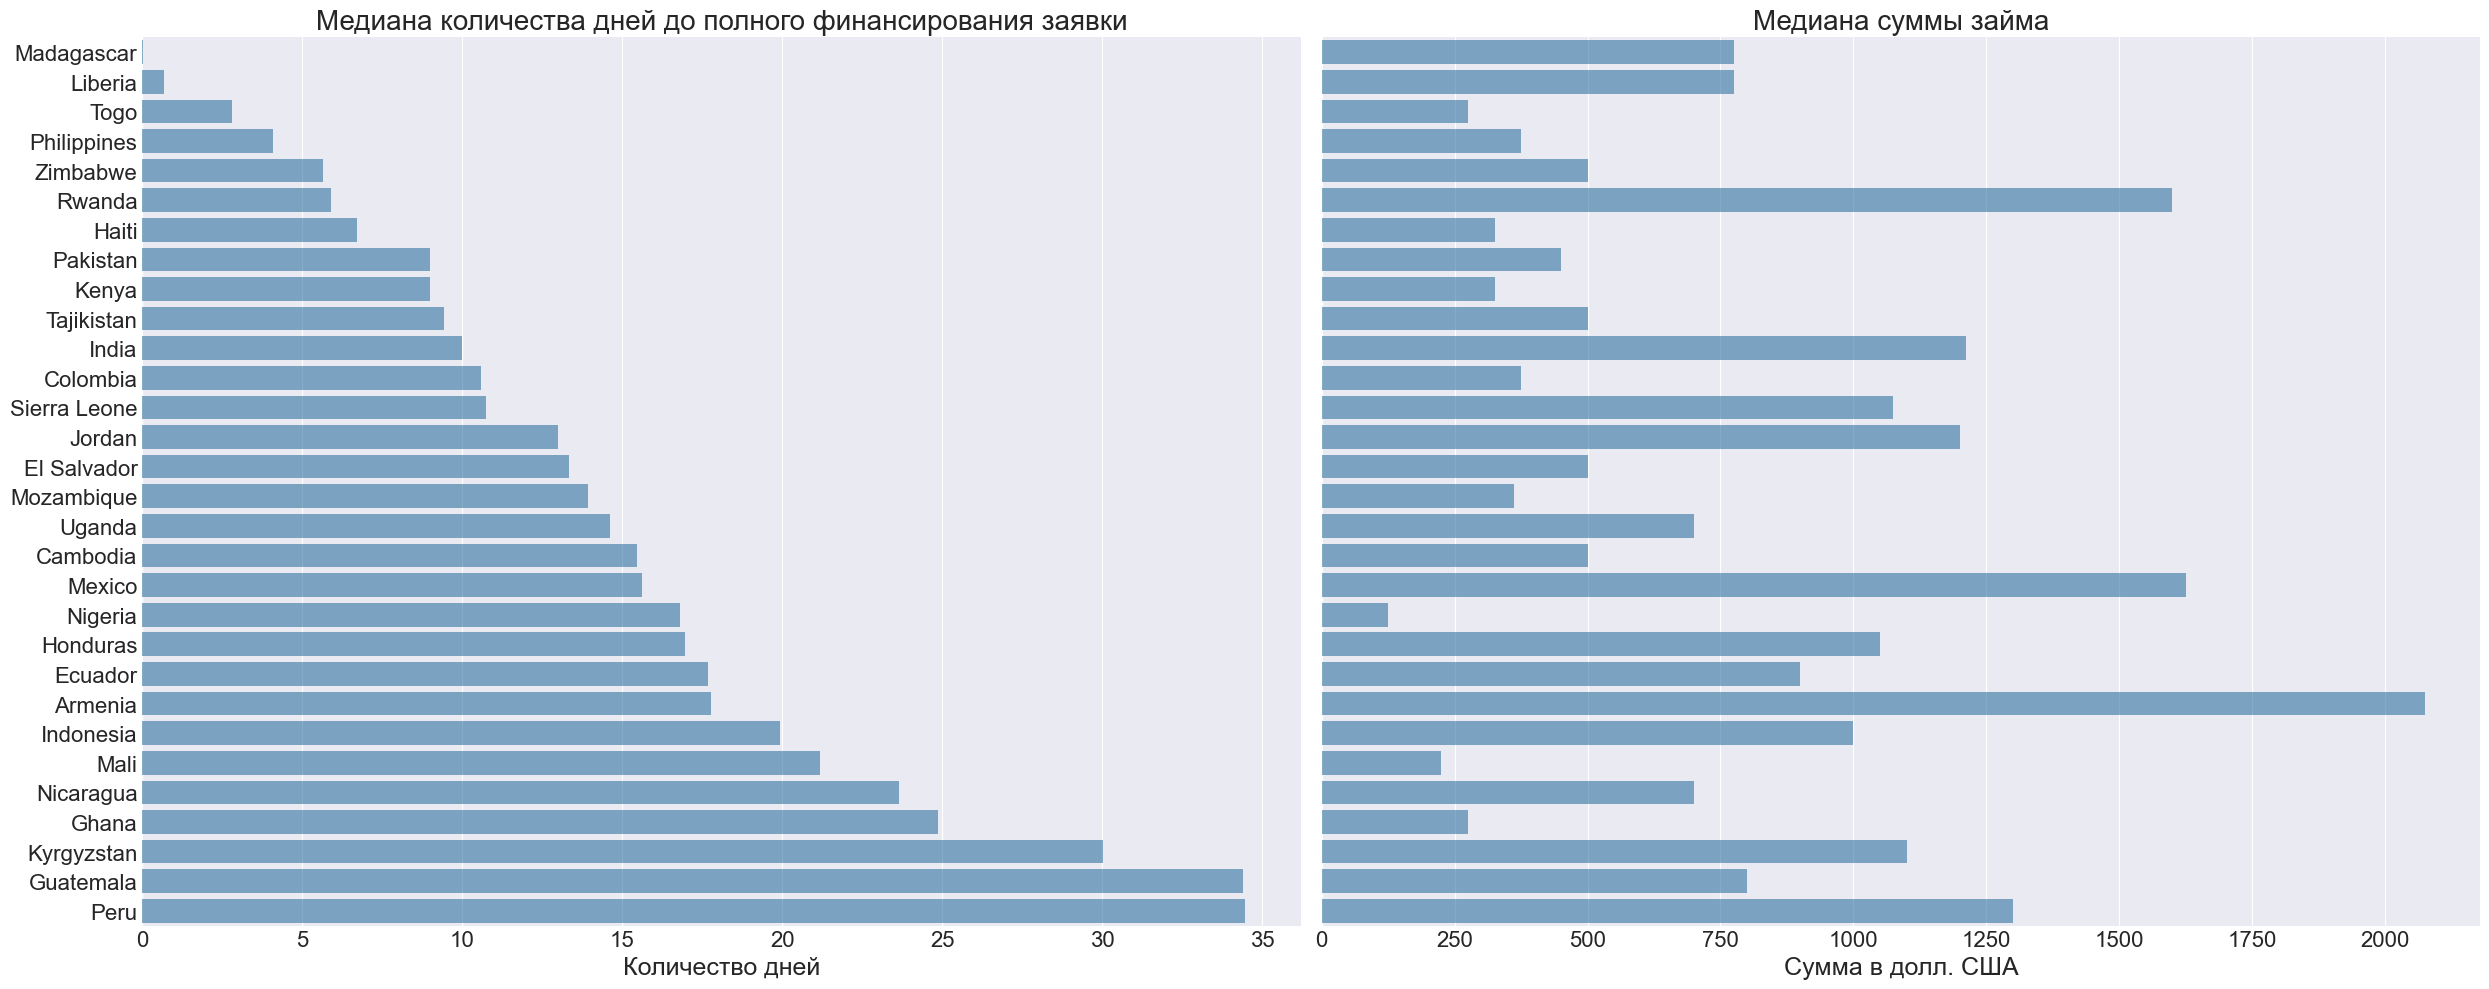

In [295]:
f,ax=plt.subplots(1, 2, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='time_funding', data=df_country_median, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана количества дней до полного финансирования заявки", fontsize=20)
ax[0].set_xlabel('Количество дней', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='loan_amount', data=df_country_median, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана суммы займа", fontsize=20)
ax[1].set_xlabel('Сумма в долл. США', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

Прямой связи времени ожидания финансирования и суммой займа не наблюдается

Посмотрим как влияет количество кредиторов (lender_count) на суммы и сроки займов

In [310]:
# Уберем записи с нулевым количеством кредиторов
loans_not_null_lender = df_kiva_loans[df_kiva_loans.lender_count > 0]

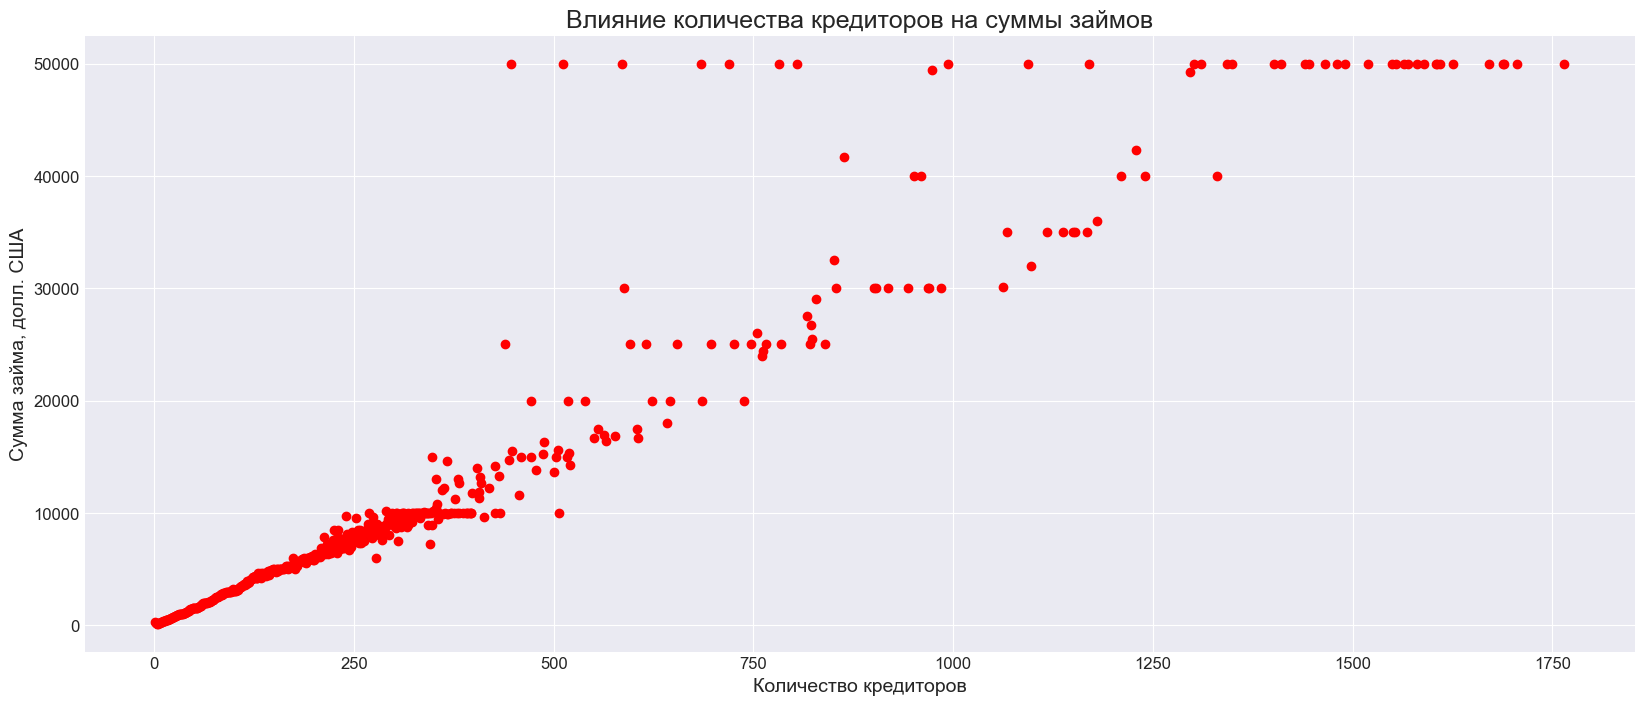

In [316]:
loans_by_lender_count = loans_not_null_lender.groupby("lender_count")["loan_amount"].median()
loans_by_lender_count = loans_by_lender_count[loans_by_lender_count < 100000]

plt.figure(figsize=(20, 8))
plt.title("Влияние количества кредиторов на суммы займов", fontsize=18)
plt.xlabel("Количество кредиторов", fontsize=14)
plt.ylabel("Сумма займа, долл. США", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(loans_by_lender_count.index, loans_by_lender_count.values, c="r");

Мы видим прямую зависимость между количеством кредиторов и суммы займов

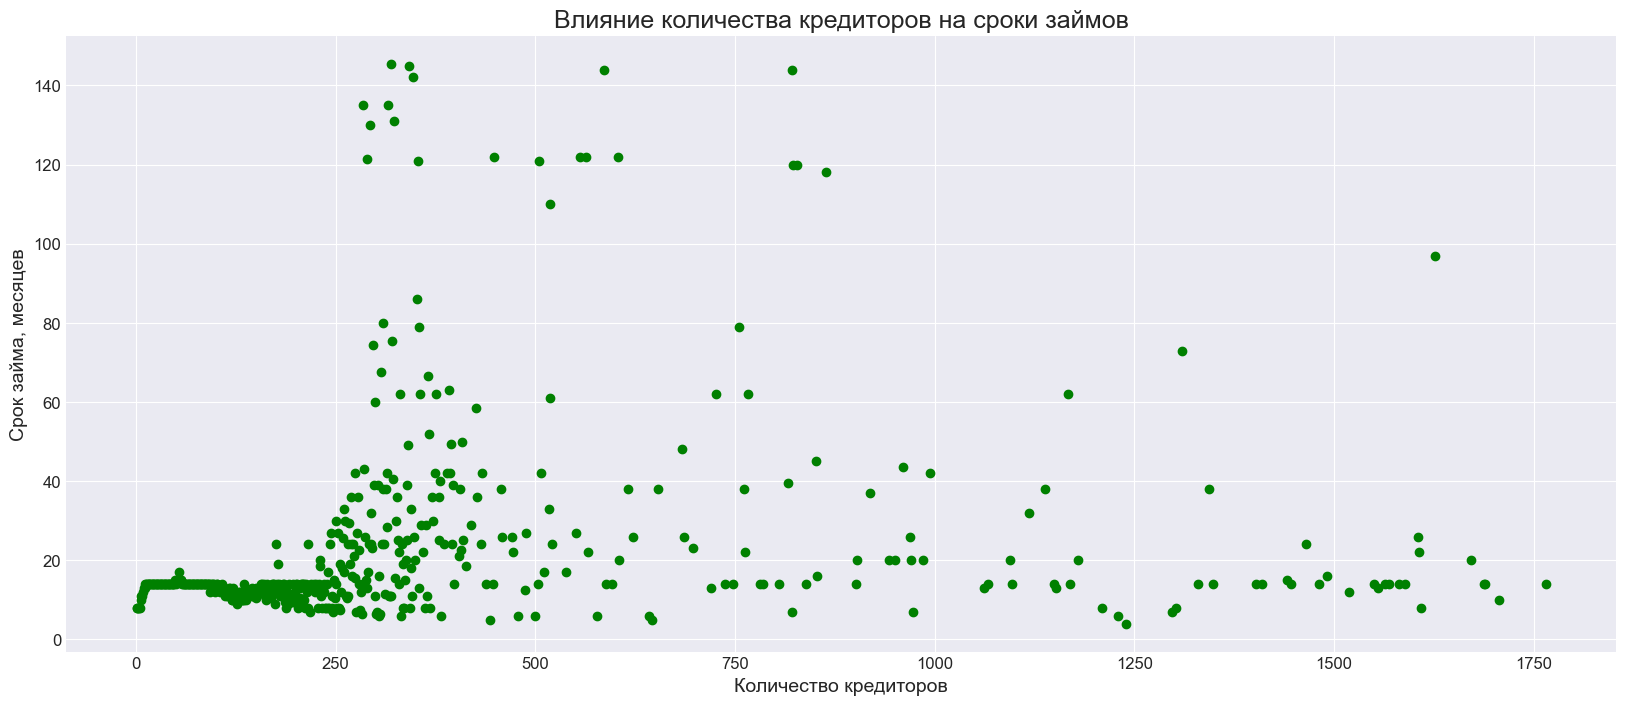

In [313]:
term_by_lender_count = loans_not_null_lender.groupby("lender_count")["term_in_months"].median()
term_by_lender_count = term_by_lender_count[term_by_lender_count.index < 2000]

plt.figure(figsize=(20, 8))
plt.title("Влияние количества кредиторов на сроки займов", fontsize=18)
plt.xlabel("Количество кредиторов", fontsize=14)
plt.ylabel("Срок займа, месяцев", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(term_by_lender_count.index, term_by_lender_count.values, c="g"); 

Взаимосвязи между количеством кредиторов и сроком займа нет

Рассмотрим сумму ежемесячного платежа в разрезе стран

In [296]:
df_country_median = df_country_median.sort_values(by='term_in_months')

In [297]:
df_country_median['monthly_repayment'] = df_country_median['loan_amount'] / df_country_median['term_in_months']

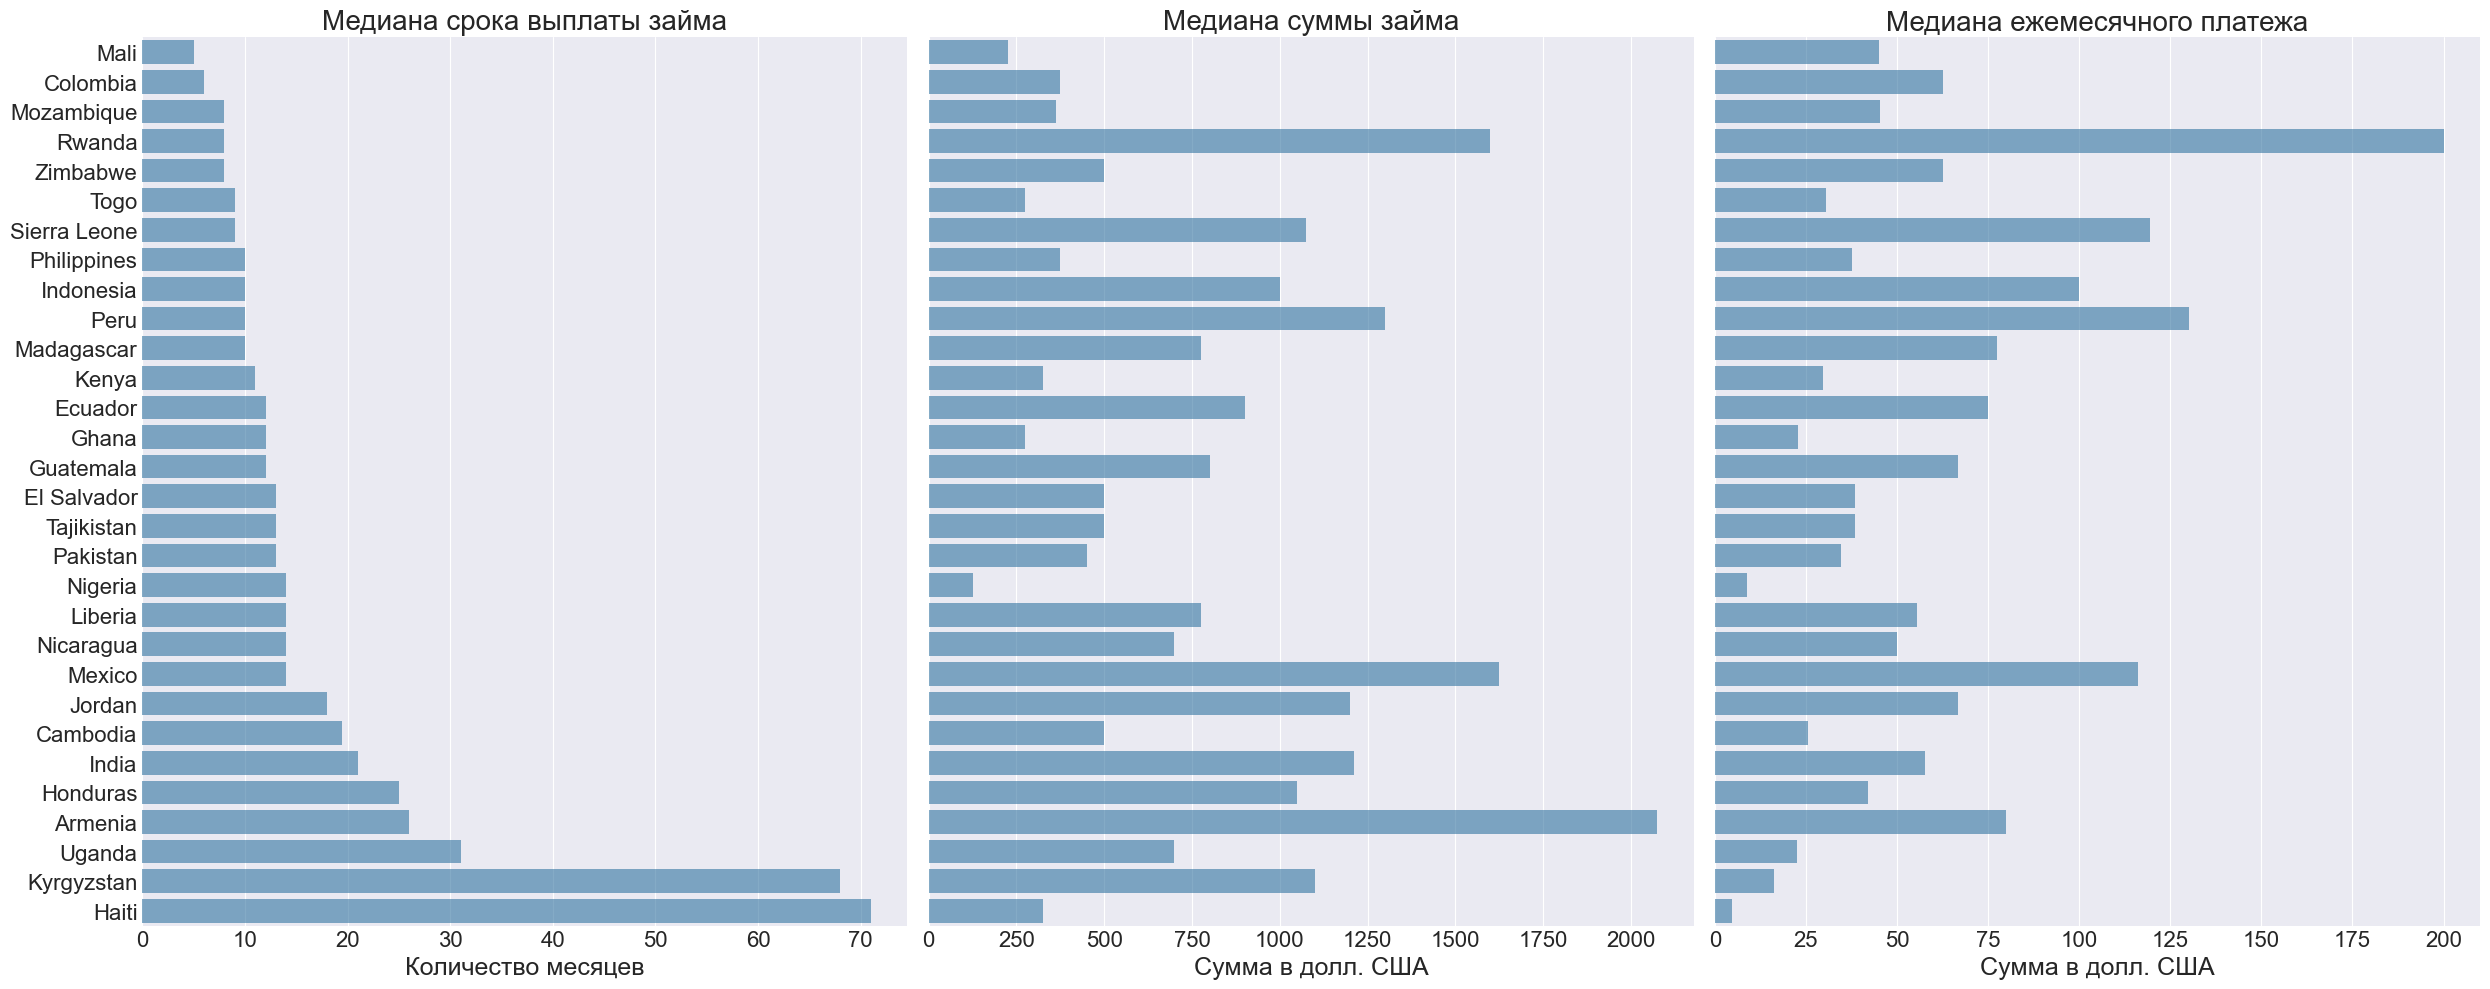

In [298]:
f,ax=plt.subplots(1, 3, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='term_in_months', data=df_country_median, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана срока выплаты займа", fontsize=20)
ax[0].set_xlabel('Количество месяцев', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='loan_amount', data=df_country_median, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана суммы займа", fontsize=20)
ax[1].set_xlabel('Сумма в долл. США', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

sns.barplot(y='country', x='monthly_repayment', data=df_country_median, alpha=0.6, ax=ax[2])
ax[2].set_title("Медиана ежемесячного платежа", fontsize=20)
ax[2].set_xlabel('Сумма в долл. США', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

Мы видим страны Гаити, Нигерия, Киргизия, Уганда и гана, где люди могут позволить себе выплачивать суммы значительно меньшие, чем в других странах, — а значит, и уровень бедности там выше.

Рассмотрим показатель MPI (многомерный индекс бедности) в разных странах и его влияние на суммы займов и сроки погашения

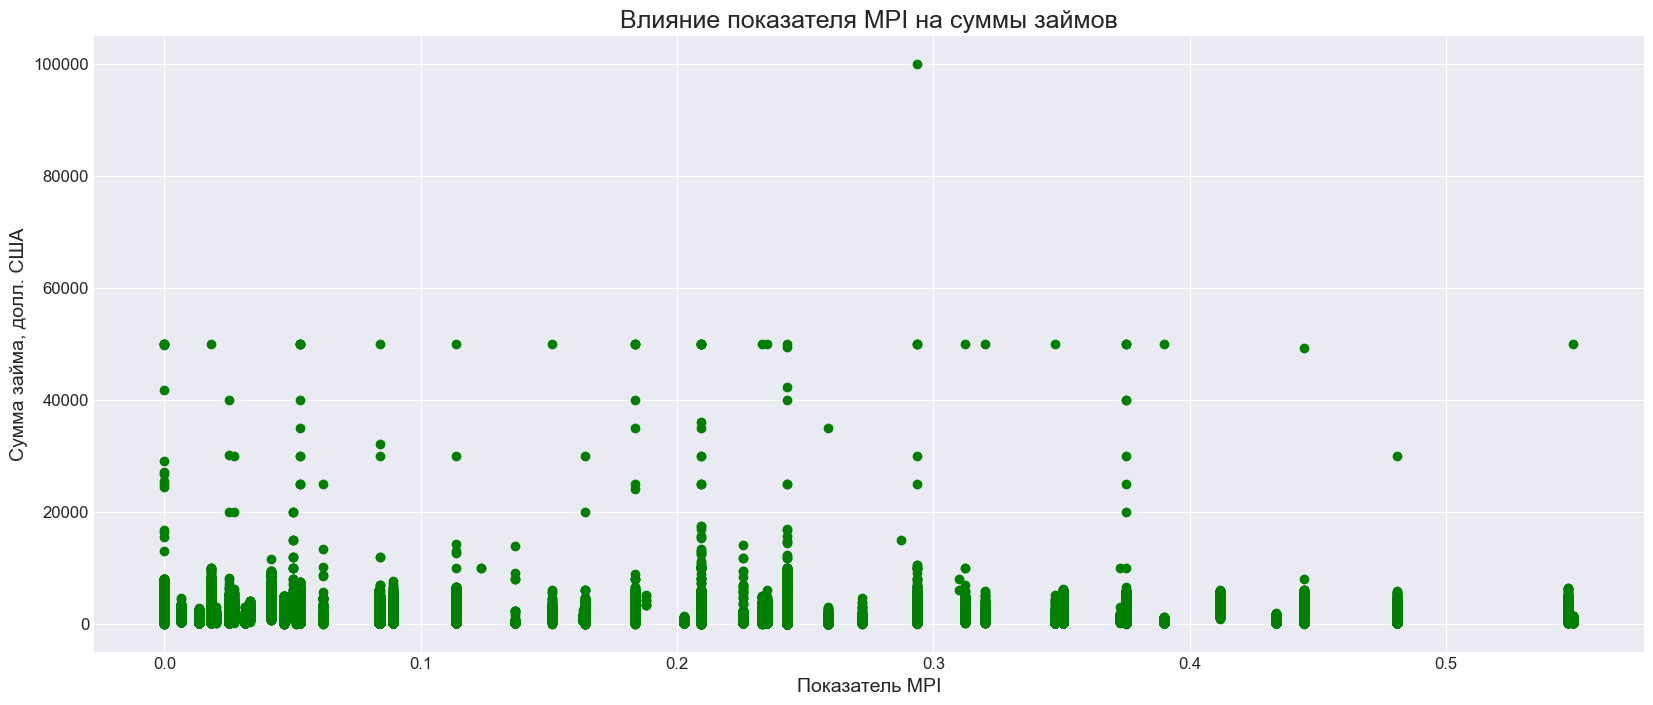

In [317]:
plt.figure(figsize=(20, 8))
plt.title("Влияние показателя MPI на суммы займов", fontsize=18)
plt.xlabel("Показатель MPI", fontsize=14)
plt.ylabel("Сумма займа, долл. США", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(df_kiva_loans.MPI, df_kiva_loans.loan_amount, c="g");

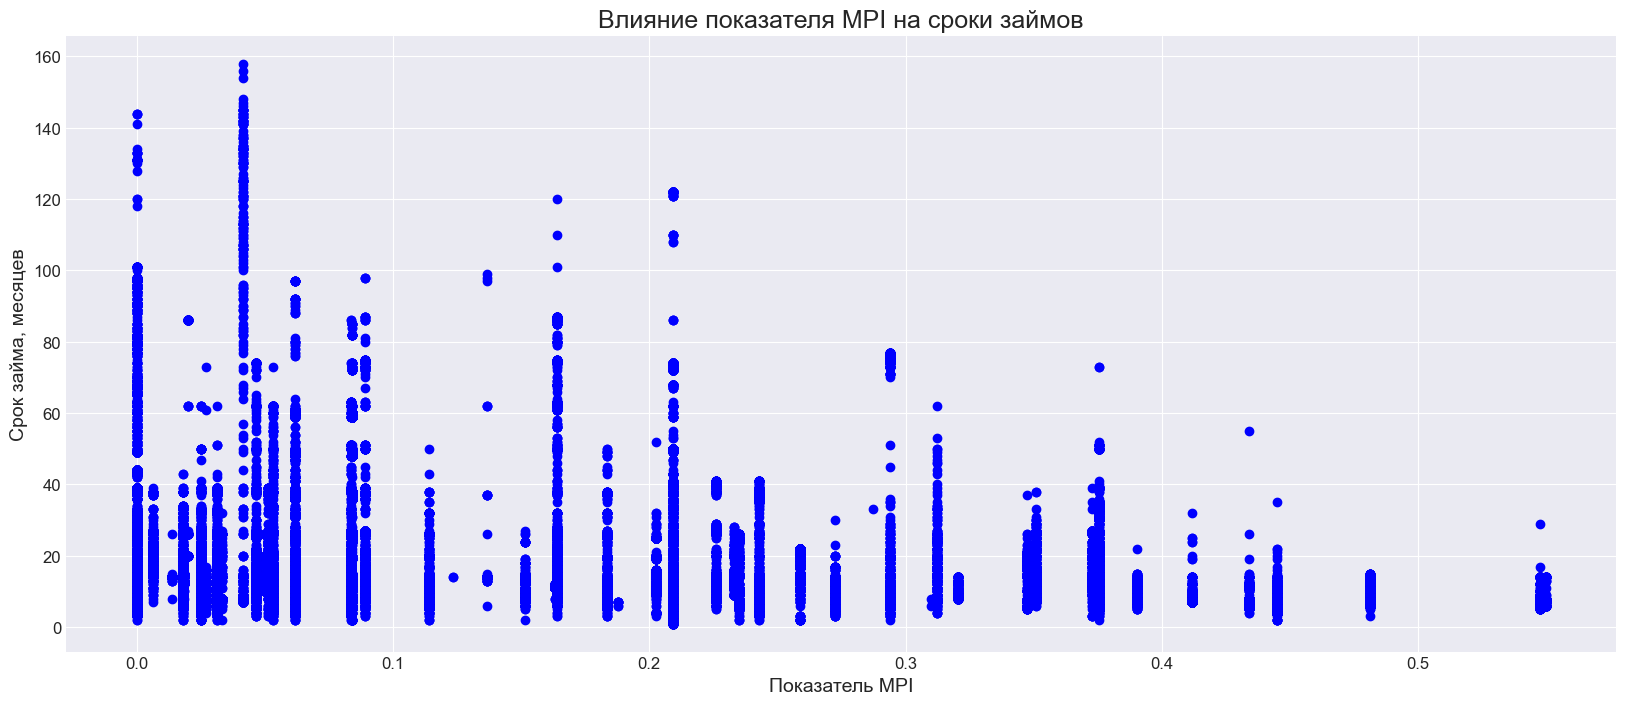

In [318]:
plt.figure(figsize=(20, 8))
plt.title("Влияние показателя MPI на сроки займов", fontsize=18)
plt.xlabel("Показатель MPI", fontsize=14)
plt.ylabel("Срок займа, месяцев", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(df_kiva_loans.MPI, df_kiva_loans.term_in_months, c="b");

В странах с высоким MPI (> 0.4) люди берут небольшие займы на короткие сроки.

Рассмотрим взаимозависимости «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж» в разрезе макрорегионов

In [319]:
loan_amount_by_world_region = df_kiva_loans.groupby("world_region")["loan_amount"].median()

term_in_months_by_world_region = df_kiva_loans.groupby("world_region")["term_in_months"].median()

In [320]:
ft_tmp = df_kiva_loans[["world_region", "posted_time", "funded_time"]].dropna()
ft_tmp["delta_time"] = pd.to_datetime(ft_tmp.funded_time) - pd.to_datetime(ft_tmp.posted_time)
ft_tmp.delta_time = ft_tmp.delta_time.round("D").dt.days.astype("int")
funding_time_by_world_region = ft_tmp.groupby("world_region")["delta_time"].median()

In [321]:
mr_temp = df_kiva_loans[["world_region", "loan_amount", "term_in_months"]].dropna()
mr_temp["monthly_repayment"] = mr_temp.loan_amount / mr_temp.term_in_months
monthly_repayment_by_world_region = mr_temp.groupby("world_region")["monthly_repayment"].median()

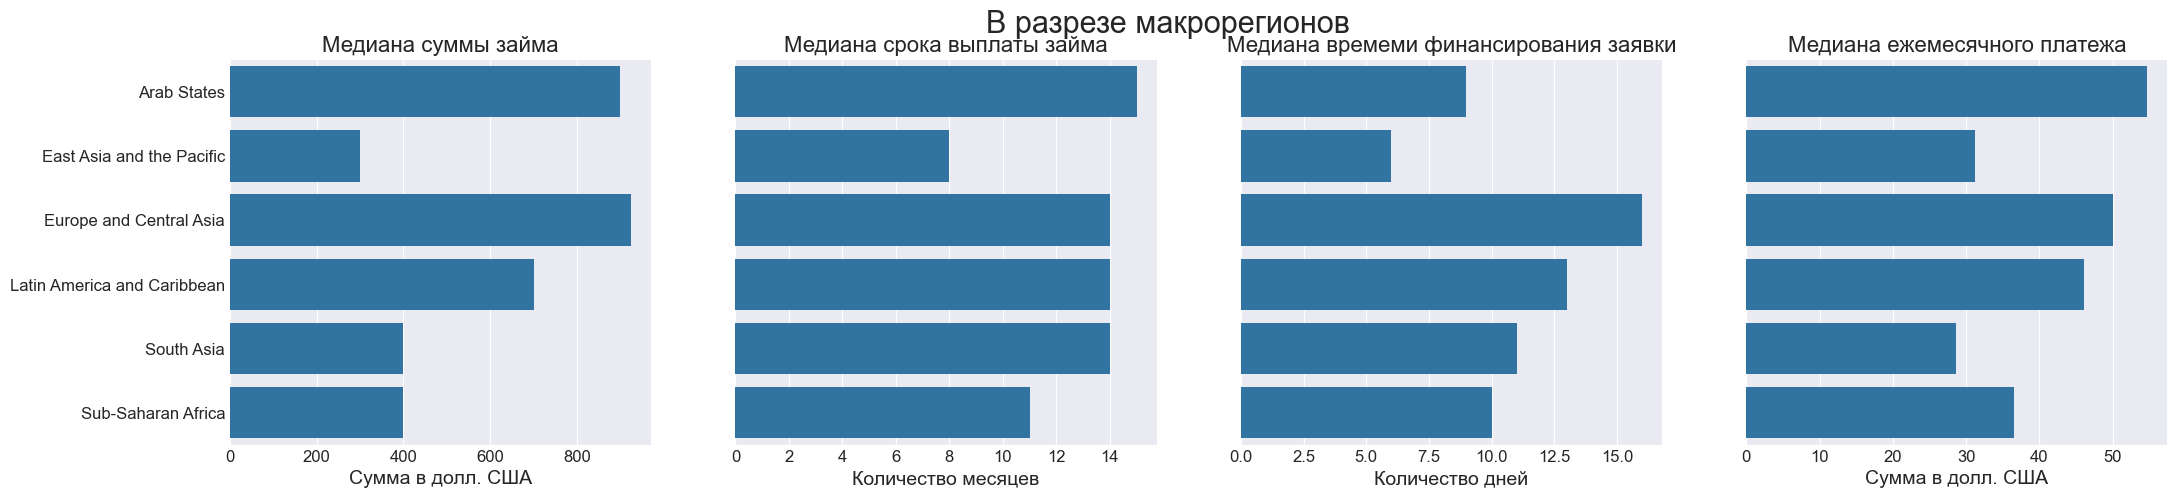

In [323]:
f, ax = plt.subplots(1, 4, sharey=True, figsize=(25, 5))


sns.barplot(
    y=loan_amount_by_world_region.index, 
    x=loan_amount_by_world_region.values, 
    ax=ax[0]
)
ax[0].set_title("Медиана суммы займа", fontsize=16)
ax[0].set_xlabel('Сумма в долл. США', fontsize=14)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=12)

sns.barplot(
    y=term_in_months_by_world_region.index, 
    x=term_in_months_by_world_region.values, 
    ax=ax[1]
)
ax[1].set_title("Медиана срока выплаты займа", fontsize=16)
ax[1].set_xlabel('Количество месяцев', fontsize=14)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=12)

sns.barplot(
    y=funding_time_by_world_region.index, 
    x=funding_time_by_world_region.values, 
    ax=ax[2]
)
ax[2].set_title("Медиана времеми финансирования заявки", fontsize=16)
ax[2].set_xlabel('Количество дней', fontsize=14)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=12)

sns.barplot(
    y=monthly_repayment_by_world_region.index, 
    x=monthly_repayment_by_world_region.values, 
    ax=ax[3]
)
ax[3].set_title("Медиана ежемесячного платежа", fontsize=16)
ax[3].set_xlabel('Сумма в долл. США', fontsize=14)
ax[3].set_ylabel(None)
ax[3].tick_params(labelsize=12)

f.suptitle("В разрезе макрорегионов", fontsize=22)

plt.show()

В Арабских странах заявки финансируются довольно быстро в сравнении со странами Европы и Центральной Азии, где суммы займа, срок выплаты займа и ежемесячный платеж сопоставимы, но заявки финансируются почти в 2 раза медленнее. Также видно, что при одинаковых суммах займа в странах Южной Азии и Центральной Африки, заявки на кредиты в последней финансируются быстрее, возможно потому, что сумма ежемесячного платежа выше и срок выплаты платежа меньше.

# Выводы

Kiva играет важную роль в поддержке операционной деятельности для многих людей, часто заменяя частный банковский сектор.


Необходимо оказывать адресную помощь самым недофинансированным странам с высоким уровнем бедности. Стоит стимулировать выдачу небольших займов, обеспечивающих занятость населения, используя опыт Филиппин. Делить заявки из небогатых стран на короткие займы.


Обеспечивать равный доступ к финансированию для женщин и мужчин, обращая внимание на страны, где баланс нарушен. Публиковать личные истории успеха женщин и мужчин на различных платформах.


Приоритетны заявки на развитие отраслей с высокой добавленной стоимостью, стимулирующие производство. Использовать умные рекомендательные системы для их продвижения.


Не оставлять без внимания заявки на удовлетворение базовых потребностей, включая их в почтовые рассылки. Финансирование крупных проектов важно для инфраструктурных проектов.


Расширять присутствие в регионах, таких как Южная Азия (Пакистан и Индия). Сглаживать неравенство между странами, регулируя поисковую выдачу и рассылки.